# Dual impact of empty sites (Z/AI) on spatial invasion and fixation

## Initialization

In [2]:
# import modules
import numpy as np
import pandas as pd
import networkx as nx
import multiprocess as mp
import csv
import random
import time
from sympy import *
## plot figures
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
### colormap
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib import rc
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
rcParams.update({'figure.autolayout': True})
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
rcParams['hatch.linewidth'] = 3
## compress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# save figures in the folder
_Figure_PATH_ = './figures/'
_Data_PATH_ = './data/'

# default colors of matplotlib
colors = ['C0', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', 
          '#17becf']
colors_heatmap = ['#E4B1BB', '#F5E2E7', '#A0AAC3', '#7282A0', '#2C3E5B']
palette_0 = ['#89B9AD', '#9CB4CC', '#F2D7D9']
palette_1 = [colors[2], colors[0], colors[3]]
def truncate_colormap(cmap, minval = 0.0, maxval = 1.0, n = 100):
    cmap_new = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n = cmap.name, a = minval, b = maxval),
        cmap(np.linspace(minval, maxval, n)))
    return cmap_new

## Symbolic Calculation

In [5]:
R, S, T, P, u = symbols('R, S, T, P, u', real = True) # payoff structure
alpha_A, alpha_B = symbols('alpha_A, alpha_B', real = True) # effects of empty sites
beta = symbols('beta', nonnegative = True) # selection strength
k = symbols('k', integer = True, positive = True) # network degree
N_e, N, i = symbols('N_e, N, i', integer = True, positive = True)
x, y = symbols('x, y', nonnegative = True)
# fractions of stratey A, strategy B, and strategy C (empty sites)
p_A, p_B, p_C, p_e = symbols('p_A, p_B, p_C, p_e', nonnegative = True) 
# fractions of edges
p_AA, p_AB, p_BA, p_BB = symbols('p_AA, p_AB, p_BA, p_BB', nonnegative = True)
p_AC, p_BC, p_CA, p_CB, p_CC = symbols('p_AC, p_BC, p_CA, p_CB, p_CC', nonnegative = True)
p_Ae, p_Be, p_eA, p_eB, p_ee = symbols('p_Ae, p_Be, p_eA, p_eB, p_ee', nonnegative = True)
# conditional probabilities: q_X|Y is the probability of X given Y
q_AA, q_BA, q_AB, q_BB = symbols('q_A|A, q_B|A, q_A|B, q_B|B', nonnegative = True)
# payoffs
pi_AA, pi_BA, pi_AB, pi_BB = symbols('pi^A_A, pi^B_A, pi^A_B, pi^B_B', real = True) 
init_printing(use_unicode = True) # for a good presentation of mathematics

## 🥕🥕🥕 Supporting Information 🥕🥕🥕

### Equation (SI8)

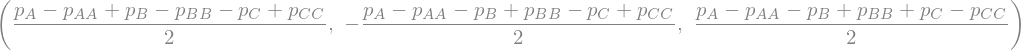

In [8]:
solutions = solve((Eq(p_A + p_B + p_C, 1), 
                   Eq(p_AB - p_BA, 0), Eq(p_BC - p_CB, 0), Eq(p_CA - p_AC, 0),
                   Eq(p_A - p_AA - p_AB - p_AC, 0), Eq(p_B - p_BA - p_BB - p_BC, 0), 
                   Eq(p_C - p_CA - p_CB - p_CC, 0)), (p_AB, p_BA, p_BC, p_CB, p_CA, p_AC))

factor(solutions[p_AB]), factor(solutions[p_BC]), factor(solutions[p_CA])

In [12]:
# conditional numbers of neighbors:
# k^X_Y is the number of X neighbors of the focal Y individual
k_AA, k_BA, k_CA = symbols('k^A_A, k^B_A, k^C_A', integer = True, nonnegative = True) 
k_AB, k_BB, k_CB = symbols('k^A_B, k^B_B, k^C_B', integer = True, nonnegative = True)
# conditional numbers of neighbors of neighbors with pair approximation
l_AA, l_BA, l_CA = symbols('l^A_A, l^B_A, l^C_A', integer = True, nonnegative = True) 
l_AB, l_BB, l_CB = symbols('l^A_B, l^B_B, l^C_B', integer = True, nonnegative = True) 
# payoffs and fitness
f_AA = exp(beta*((l_AA + 1)*R + l_BA*S + l_CA*alpha_A))
f_BA = exp(beta*((l_AB + 1)*T + l_BB*P + l_CB*alpha_B))
f_AB = exp(beta*(l_AA*R + (l_BA + 1)*S + l_CA*alpha_A))
f_BB = exp(beta*(l_AB*T + (l_BB + 1)*P + l_CB*alpha_B))

# k is an integer: multinomal distribution
# for easier calculation, consider first binomial and then trinomial
## neighbors
### of an A individual
dist_A = binomial(k, k_BA)*q_BA**k_BA*p_e**(k - k_BA) # substitute k with k - k_AA
### of a B individual
dist_B = binomial(k, k_BB)*q_BB**k_BB*p_e**(k - k_BB) # substitute k with k - k_AB
## neighbors 
### of an A neighbor except for the focal individual
bist_A = binomial(k, l_BA)*q_BA**l_BA*p_e**(k - l_BA) # substitute k with k - 1 - l_AA
### of a B neighbor except for the focal individual
bist_B = binomial(k, l_BB)*q_BB**l_BB*p_e**(k - l_BB) # substitute k with k - 1 - l_AB

### Equation (SI18) and more

In [14]:
# cores
# Taylor expansion with respect to beta = 0 to the first degree + O(beta^2)
## a focal B individual being replaced by a neighbor A individual
terms_AB = factor(k_AB*f_AB/(k_AB*f_AB + k_BB*f_BB + k_CB*1)).series(beta, x0 = 0, n = 2)
terms_AB = terms_AB.as_ordered_terms() # c_0 + c_1*beta + O(beta^2)
terms_AB0 = factor(terms_AB[0].subs({k_CB: k - k_AB - k_BB})) # constant term
terms_AB1 = factor(terms_AB[1].subs({k_CB: k - k_AB - k_BB})) # first-degree term
terms_AB1 = collect(collect(collect(collect(collect(collect(terms_AB1, l_AA), l_BA), l_CA), \
                                    l_AB), l_BB), l_CB)
## a focal A individual being replaced by a neighor B individual
terms_BA = factor(k_BA*f_BA/(k_AA*f_AA + k_BA*f_BA + k_CA*1)).series(beta, x0 = 0, n = 2)
terms_BA = terms_BA.as_ordered_terms()
terms_BA0 = factor(terms_BA[0].subs({k_CA: k - k_AA - k_BA}))
terms_BA1 = factor(terms_BA[1].subs({k_CA: k - k_AA - k_BA}))
terms_BA1 = collect(collect(collect(collect(collect(collect(terms_BA1, l_AA), l_BA), l_CA), \
                                    l_AB), l_BB), l_CB)

### Test

> a focal A individual

* #### one-fold

In [19]:
# multinomial distribution times k_AA
test_AA = summation(dist_A*k_AA, (k_BA, 0, k)) # summations wrt B and C
test_AA = cancel(test_AA.args[0]*test_AA.args[1].args[0][0]).subs({k: k - k_AA})
test_AA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AA, (k_AA, 0, k)) # summations wrt A
test_AA = cancel(factor(test_AA.args[0][0]))
test_AA = simplify(test_AA.subs({q_BA: 1 - p_e - q_AA}))
# multinomial distribution times k_BA
test_BA = cancel(summation(dist_A*k_BA, (k_BA, 0, k)).args[0][0]).subs({k: k - k_AA})
test_BA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BA, (k_AA, 0, k))
test_BA = cancel(test_BA.args[0]*test_BA.args[1].args[0][0])
test_BA = simplify(test_BA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_CA = k - k_AA - k_BA
test_CA = summation(dist_A*(k - k_BA), (k_BA, 0, k))
test_CA = cancel(test_CA.args[0].args[0]*test_CA.args[0].args[1].args[0][0] + 
                 test_CA.args[1].args[0]*test_CA.args[1].args[1].args[0][0])
test_CA = cancel(factor(test_CA.subs({k: k - k_AA})))
test_CA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CA, (k_AA, 0, k))
test_CA = cancel(test_CA.args[0].args[0]*test_CA.args[0].args[1].args[0][0] + 
                 test_CA.args[1].args[0]*test_CA.args[1].args[1].args[0][0] + 
                 test_CA.args[2].args[0]*test_CA.args[2].args[1]*test_CA.args[2].args[2].args[0][0])
test_CA = simplify(test_CA.subs({q_AA: 1 - q_BA - p_e}))
test_AA, test_BA, test_CA

* #### two-fold

In [22]:
# multinomial distribution times k_AA*k_BA
test_AABA = summation(dist_A*k_AA*k_BA, (k_BA, 0, k))
test_AABA = cancel(test_AABA.args[0]*test_AABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AABA, (k_AA, 0, k))
test_AABA = cancel(test_AABA.args[0]*test_AABA.args[1].args[0][0])
test_AABA = simplify(test_AABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA*k_CA
test_BACA = summation(dist_A*k_BA*(k - k_BA), (k_BA, 0, k))
test_BACA = cancel(test_BACA.args[0].args[0]*test_BACA.args[0].args[1].args[0][0] + 
                   test_BACA.args[1].args[0]*test_BACA.args[1].args[1].args[0][0])
test_BACA = cancel(factor(test_BACA.subs({k: k - k_AA})))
test_BACA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BACA, (k_AA, 0, k))
temps = [test_BACA.args[i] for i in range(3)]
test_BACA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2]*temps[i].args[3]*
                           temps[i].args[4].args[0][0] for i in range(3)]))
test_BACA = simplify(test_BACA.subs({q_AA: 1 - q_BA - p_e}))
# multinomial distribution times k_CA*k_AA
test_CAAA = summation(dist_A*(k - k_BA)*k_AA, (k_BA, 0, k))
temps = [test_CAAA.args[i] for i in range(2)]
test_CAAA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2].args[0][0] for i in range(2)]))
test_CAAA = cancel(factor(test_CAAA.subs({k: k - k_AA})))
test_CAAA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CAAA, (k_AA, 0, k))
test_CAAA = cancel(test_CAAA.args[0].args[0]*test_CAAA.args[0].args[1].args[0][0] + 
                   test_CAAA.args[1].args[0]*test_CAAA.args[1].args[1].args[0][0] + 
                   test_CAAA.args[2].args[0]*test_CAAA.args[2].args[1]*test_CAAA.args[2].args[2].args[0][0])
test_CAAA = simplify(test_CAAA.subs({q_BA: 1 - q_AA - p_e}))
test_AABA, test_BACA, test_CAAA

In [23]:
# multinomial distribution times k_AA*k_AA
test_AAAA = summation(dist_A*k_AA**2, (k_BA, 0, k))
test_AAAA = cancel(test_AAAA.args[0]*test_AAAA.args[1].args[0][0]).subs({k: k - k_AA})
test_AAAA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AAAA, (k_AA, 0, k))
test_AAAA = cancel(factor(test_AAAA.args[0][0]))
test_AAAA = simplify(test_AAAA.subs({q_BA: 1 - p_e - q_AA}))
# multinomial distribution times k_BA*k_BA
test_BABA = summation(dist_A*k_BA**2, (k_BA, 0, k))
test_BABA = cancel(test_BABA.args[0][0].subs({k: k - k_AA}))
test_BABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BABA, (k_AA, 0, k))
temps = [test_BABA.args[i] for i in range(3)]
test_BABA = cancel(np.sum([temps[i].args[0]*temps[i].args[1]*temps[i].args[2]*temps[i].args[3].args[0][0] 
                           for i in range(3)]))
test_BABA = simplify(test_BABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_CA*k_CA
test_CACA = summation(dist_A*(k - k_BA)**2, (k_BA, 0, k))
test_CACA = cancel(test_CACA.args[0].args[0]*test_CACA.args[0].args[1].args[0][0] + 
                   test_CACA.args[1].args[0]*test_CACA.args[1].args[1]*test_CACA.args[1].args[2].args[0][0] + 
                   test_CACA.args[2].args[0][0])
test_CACA = cancel(test_CACA.subs({k: k - k_AA}))
test_CACA = summation(binomial(k, k_AA)*q_AA**k_AA*test_CACA, (k_AA, 0, k))
temps = [test_CACA.args[i] for i in range(11)]
test_CACA = cancel(np.sum([np.product([temps[i].args[j] 
                                       for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                           for i in range(11)]))
test_CACA = simplify(test_CACA.subs({q_AA: 1 - q_BA - p_e}))
test_AAAA, test_BABA, test_CACA

* #### three-fold

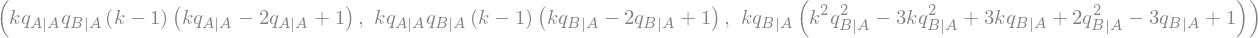

In [25]:
# multinomial distribution times k_AA**2*k_BA
test_AAAABA = summation(dist_A*k_AA**2*k_BA, (k_BA, 0, k))
test_AAAABA = cancel(test_AAAABA.args[0]*test_AAAABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AAAABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AAAABA, (k_AA, 0, k))
test_AAAABA = cancel(test_AAAABA.args[0]*test_AAAABA.args[1].args[0][0])
test_AAAABA = simplify(test_AAAABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA**2*k_AA
test_AABABA = summation(dist_A*k_AA*k_BA**2, (k_BA, 0, k))
test_AABABA = cancel(test_AABABA.args[0]*test_AABABA.args[1].args[0][0]).subs({k: k - k_AA})
test_AABABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_AABABA, (k_AA, 0, k))
temps = [test_AABABA.args[i] for i in range(3)]
test_AABABA = cancel(np.sum([np.product([temps[i].args[j] 
                                         for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                             for i in range(3)]))
test_AABABA = simplify(test_AABABA.subs({p_e: 1 - q_AA - q_BA}))
# multinomial distribution times k_BA**3
test_BABABA = summation(dist_A*k_BA**3, (k_BA, 0, k))
test_BABABA = cancel(test_BABABA.args[0][0]).subs({k: k - k_AA})
test_BABABA = summation(binomial(k, k_AA)*q_AA**k_AA*test_BABABA, (k_AA, 0, k))
temps = [test_BABABA.args[i] for i in range(7)]
test_BABABA = cancel(np.sum([np.product([temps[i].args[j] 
                                         for j in range(np.size(temps[i].args) - 1)])*temps[i].args[-1].args[0][0] 
                             for i in range(7)]))
test_BABABA = simplify(test_BABABA.subs({p_e: 1 - q_AA - q_BA}))
test_AAAABA, test_AABABA, test_BABABA

In [26]:
# one-fold, two-fold, and three-fold (which need to be replaced indirectly by considering the detailed expressions)
## neighbors
### of an A individual
dist_A_subs = {'AA': k*q_AA, 'BA': k*q_BA, 'CA': k*p_e, 
               'AABA': k*(k - 1)*q_AA*q_BA, 
               'BACA': k*(k - 1)*q_BA*p_e, 'CAAA': k*(k - 1)*p_e*q_AA, 
               'AAAA': k*q_AA*((k - 1)*q_AA + 1), 'BABA': k*q_BA*((k - 1)*q_BA + 1), 'CACA': k*p_e*((k - 1)*p_e + 1), 
               'AAAABA': k*(k - 1)*q_AA*q_BA*((k - 2)*q_AA + 1), 
               'AABABA': k*(k - 1)*q_AA*q_BA*((k - 2)*q_BA + 1), 
               'BABABA': k*q_BA*(k*q_BA + ((k - 1)*q_BA + 1)*((k - 2)*q_BA + 1))}
### of a B individual
dist_B_subs = {'AB': k*q_AB, 'BB': k*q_BB, 'CB': k*p_e, 
               'ABBB': k*(k - 1)*q_AB*q_BB, 
               'BBCB': k*(k - 1)*q_BB*p_e, 'CBAB': k*(k - 1)*p_e*q_AB, 
               'ABAB': k*q_AB*((k - 1)*q_AB + 1), 'BBBB': k*q_BB*((k - 1)*q_BB + 1), 'CBCB': k*p_e*((k - 1)*p_e + 1),
               'ABBBBB': k*(k - 1)*q_BB*q_AB*((k - 2)*q_BB + 1), 
               'ABABBB': k*(k - 1)*q_BB*q_AB*((k - 2)*q_AB + 1), 
               'ABABAB': k*q_AB*(k*q_AB + ((k - 1)*q_AB + 1)*((k - 2)*q_AB + 1))}
# one-fold (which can be replaced directly)
## neighbors 
### of an A neighbor except for the focal individual
bist_A_subs = {l_AA: (k - 1)*q_AA, l_BA: (k - 1)*q_BA, l_CA: (k - 1)*p_e}
### of a B neighbor except for the focal individual
bist_B_subs = {l_AB: (k - 1)*q_AB, l_BB: (k - 1)*q_BB, l_CB: (k - 1)*p_e}

### Derivative of $p_A$: Equation (SI25)-1
> $W_{A\to B}- W_{B\to A}$

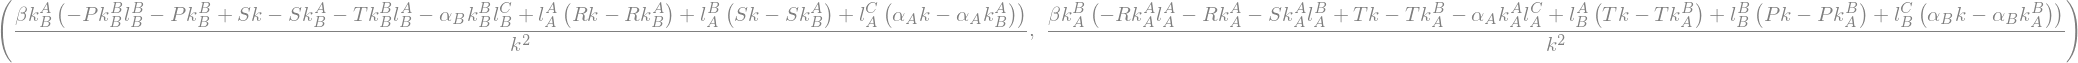

In [28]:
terms_AB0, terms_AB1
terms_AB1, terms_BA1

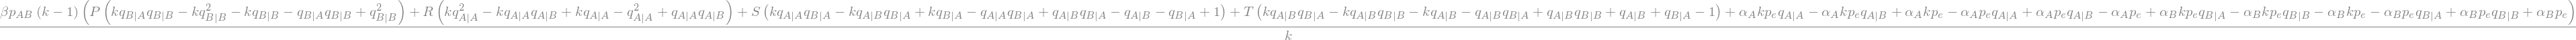

In [29]:
# integration of the core
## a focal B individual being replaced by a neighbor A individual: Equation (A19)
W_AB0 = factor(terms_AB0.coeff(k_AB, 1)*dist_B_subs['AB']) # constant term with the factor k_AB
W_AB1 = factor(terms_AB1.subs(bist_A_subs).subs(bist_B_subs)) # first-degree term
W_AB1 = expand(W_AB1)
coeff0 = factor(W_AB1.coeff(k_AB, 1).coeff(k_BB, 0)) # k_AB
coeff1 = factor(W_AB1.coeff(k_AB, 1).coeff(k_BB, 1)) # k_AB*k_BB
coeff2 = factor(W_AB1.coeff(k_AB, 2)) # k_AB**2
W_AB1 = factor(coeff0*dist_B_subs['AB'] + coeff1*dist_B_subs['ABBB'] + coeff2*dist_B_subs['ABAB'])
W_AB = p_B*(W_AB0 + W_AB1)
## a focal A individual being replaced by a neighbor B individual
W_BA0 = factor(terms_BA0.coeff(k_BA, 1)*dist_A_subs['BA']) # constant term with the factor k_BA
W_BA1 = factor(terms_BA1.subs(bist_A_subs).subs(bist_B_subs)) # first-degree term
W_BA1 = expand(W_BA1)
coeff0 = factor(W_BA1.coeff(k_BA, 1).coeff(k_AA, 0)) # k_BA
coeff1 = factor(W_BA1.coeff(k_BA, 1).coeff(k_AA, 1)) # k_AA*k_BA
coeff2 = factor(W_BA1.coeff(k_BA, 2)) # k_BA**2
W_BA1 = factor(coeff0*dist_A_subs['BA'] + coeff1*dist_A_subs['AABA'] + coeff2*dist_A_subs['BABA'])
W_BA = p_A*(W_BA0 + W_BA1)
# p_AB = p_A*q_BA = p_B*q_AB
p_A_diff = factor(W_AB.subs(p_B, p_AB/q_AB) - W_BA.subs(p_A, p_AB/q_BA))
collect(collect(collect(collect(p_A_diff, R), S), T), P)

### Derivative of $p_{AA}$: Equation (SI25)-3
> $\frac{2}{k}(\phi_{A\to B}^{AA} - \phi_{B\to A}^{AA})$

In [31]:
# integration of the core
## a focal B individual being replaced by a neighbor A individual: Equation (A21)
### constant term with the factor k_AB**2
phi_AB0 = factor((k_AB*terms_AB0).coeff(k_AB, 2)*dist_B_subs['ABAB']) 
### first-degree term
phi_AB1 = factor((k_AB*terms_AB1).subs(bist_A_subs).subs(bist_B_subs)) 
phi_AB1 = expand(phi_AB1)
coeff0 = factor(phi_AB1.coeff(k_AB, 2).coeff(k_BB, 0)) # k_AB**2
coeff1 = factor(phi_AB1.coeff(k_AB, 2).coeff(k_BB, 1)) # k_AB**2*k_BB
coeff2 = factor(phi_AB1.coeff(k_AB, 3)) # k_AB**3
phi_AB1 = factor(coeff0*dist_B_subs['ABAB'] + coeff1*dist_B_subs['ABABBB'] + coeff2*dist_B_subs['ABABAB'])
phi_AB = p_B*(phi_AB0 + phi_AB1)
## a focal A individual being replaced by a neighbor B individual
### constant term with the factor k_AA*k_BA
phi_BA0 = factor((k_AA*terms_BA0).coeff(k_BA, 1).coeff(k_AA, 1)*dist_A_subs['AABA'])
### first-degree term
phi_BA1 = factor((k_AA*terms_BA1).subs(bist_A_subs).subs(bist_B_subs))
phi_BA1 = expand(phi_BA1)
coeff0 = factor(phi_BA1.coeff(k_BA, 1).coeff(k_AA, 1)) # k_AA*k_BA
coeff1 = factor(phi_BA1.coeff(k_BA, 1).coeff(k_AA, 2)) # k_AA**2*k_BA
coeff2 = factor(phi_BA1.coeff(k_BA, 2).coeff(k_AA, 1)) # k_AA*k_BA**2
phi_BA1 = factor(coeff0*dist_A_subs['AABA'] + coeff1*dist_A_subs['AAAABA'] + coeff2*dist_A_subs['AABABA'])
phi_BA = p_A*(phi_BA0 + phi_BA1)
# p_AB = p_A*q_BA = p_B*q_AB
p_AA_diff = factor(phi_AB.subs(p_B, p_AB/q_AB) - phi_BA.subs(p_A, p_AB/q_BA))

### Equation (SI27) or Equations (21 - 22)

In [34]:
# given that the constant term of p_A_diff with respect to beta is zero 
# the constant term of p_AA_diff with respect to beta need to be zero as well
identity = cancel(factor(collect(expand(p_AA_diff), beta).coeff(beta, 0))/p_AB)
Eq(factor(1 - identity), 1)

### Equation (SI29) or Equations (19 - 20)

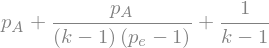

In [36]:
identity = identity.subs({q_AB: p_A/p_B*q_BA}).subs({q_BA: 1 - q_AA - p_e}).subs({p_B: 1 - p_A - p_e})
p_A + 1/(k - 1) + factor(solve(factor(identity), q_AA)[0] - p_A - 1/(k - 1))

## 🥕🥕🥕 Main text 🥕🥕🥕

## 🥞🥞🥞 Figure 1: Model schematic 🥞🥞🥞

### Network

* #### lattice
* #### random regular graph
* #### scale free network
* #### village

    [Kaggle page](https://www.kaggle.com/datasets/turhancankargin/village-relationships)

    [Paper page](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/21538)

In [39]:
# focus on village 7
# generate networks from village 7
index = 7
with open(_Data_PATH_ + 'Village_Kaggle/Data/1. Network Data/Adjacency Matrices/' + 
          'adj_allVillageRelationships_vilno_' + str(index) + '.csv', newline = '') as file:
    A0 = list(csv.reader(file))
A0 = np.array(A0)
np.fill_diagonal(A0, 0)
A0 = A0.astype(int)
G0 = nx.from_numpy_array(A0)
G0 = G0.subgraph(sorted(nx.connected_components(G0), key = len, reverse = True)[0]) # giant component

sizes = [9, 16, 25, 50, 100, 200]
dict_G = dict.fromkeys(sizes)
for size in sizes:
    plus = 0
    while plus >= 0:
        G = G0.subgraph(list(G0.nodes)[:size + plus])
        G = G.subgraph(sorted(nx.connected_components(G), key = len, reverse = True)[0])
        N_e_sub = G.number_of_nodes()
        if N_e_sub == size:
            break
        else:
            plus += 1
    dict_G[size] = G

In [40]:
def initilization_network(L = 10, W = 10, p_e_sub = 1/5, tag = 1, graph = 'lattice', palette = palette_0, alpha = 0.6,
                          fsize = (8, 6), fs = 20, plotting = False):
    '''
    L: length of lattice
    W: width of the lattice
    p_e_sub: fraction of empty sites
    p_sub: fraction of tag sites
    beta_sub: strength of selection
    tag: 1 (A) or 2 (B)
    graph: 'lattice', 'regular', 'scalefree', or 'village'
    '''
    # network structure
    if graph == 'lattice':
        G = nx.grid_2d_graph(L, W, periodic = True)
    elif graph == 'random':
        G = nx.random_regular_graph(d = 4, n = L*W, seed = None)
    elif graph == 'scalefree':
        G0 = nx.random_regular_graph(d = 4, n = 4 + 1, seed = None)
        G = nx.barabasi_albert_graph(n = L*W, m = int(4/2), initial_graph = G0)
    else:
        G = dict_G[L*W]
    
    # status
    N_e_sub = L*W
    N_sub = int(N_e_sub*(1 - p_e_sub))
    if plotting:
        p_sub = 1/2
        H = np.concatenate([np.random.randint(tag, tag + 1, int(N_sub*p_sub)), # integers of tag
                            np.random.randint(3 - tag, 4 - tag, N_sub - int(N_sub*p_sub)), # integers of the other
                            np.random.randint(0, 1, N_e_sub - N_sub)]) # integers of 0 (empty site)
    else:
        H = np.concatenate([np.random.randint(tag, tag + 1, 1), # integers of tag
                            np.random.randint(3 - tag, 4 - tag, N_sub - 1), # integers of the other
                            np.random.randint(0, 1, N_e_sub - N_sub)]) # integers of 0 (empty site)
    random.shuffle(H)
    
    for j, item in enumerate(G.nodes):
        G.nodes[item]['state'] = H[j]
    G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    # !!! !!! !!! !!! all the non-empty sites are connected !!! !!! !!! !!!
    while not nx.is_connected(G_AB):
        random.shuffle(H)
        for j, item in enumerate(G.nodes):
            G.nodes[item]['state'] = H[j]
        G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])

    if plotting:
        cmap = [] # node color 
        smap = [] # node size
        for j, item in enumerate(G.nodes):
            cmap.append(palette[G.nodes[item]['state']])
            if G.nodes[item]['state'] == tag:
                smap.append(100) # 200
            else:
                smap.append(100)
        
        fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [7, 1]}, figsize = fsize)
        sns.set_style('white')
        sns.despine(left = True, bottom = True)
        fig.patch.set_facecolor('white')
        # pos = nx.spring_layout(G) # k = 1/np.sqrt(G.order()), seed = 1969
        pos = nx.nx_agraph.graphviz_layout(G)
        if graph == 'lattice':
            pos = {key: key for key in pos}
        
        cmap = mcolors.LinearSegmentedColormap.from_list('Custom', palette, len(palette))
        ec = nx.draw_networkx_edges(G, pos, alpha = 0.25, width = 4, ax = ax0)
        # nc = nx.draw_networkx_nodes(G, pos, nodelist = G.nodes(), node_color = H, node_size = 600, cmap = cmap, alpha = alpha, ax = ax0)
        # draw square nodes (state == 0)
        square_nodes = [node for node in G.nodes() if G.nodes[node]['state'] == 0]
        nx.draw_networkx_nodes(G, pos, nodelist = square_nodes, node_color = palette[0], node_shape = 's', node_size = 600, alpha = alpha, 
                               ax = ax0)
        # draw circle nodes (state == 1 or 2)
        circle_nodes_A = [node for node in G.nodes() if G.nodes[node]['state'] == 1]
        nx.draw_networkx_nodes(G, pos, nodelist = circle_nodes_A, node_color = palette[1], node_shape = 'o', node_size = 600, 
                               alpha = alpha, ax = ax0)
        circle_nodes_B = [node for node in G.nodes() if G.nodes[node]['state'] == 2]
        nx.draw_networkx_nodes(G, pos, nodelist = circle_nodes_B, node_color = palette[2], node_shape = 'o', node_size = 600, 
                               alpha = alpha, ax = ax0)
        
        ax0.set_xticklabels([])
        ax0.set_yticklabels([])
        
        dict_title = {'lattice': 'degree-regular lattice', 'random': 'degree-regular random network', 
                      'scalefree': 'degree-heterogeneous scale-free network', 'village': 'real village network'}
        dict_title = {'lattice': 'lattice', 'random': 'random network', 
                      'scalefree': 'scale-free', 'village': 'real village'}
        ax0.set_title(dict_title[graph], fontsize = fs) # y = 1.01
        
        # subfigure: legend
        ax1.axis('off')
        # optional: add an invisible dummy marker to even out top/bottom
        dummy = mlines.Line2D([], [], color = 'none', marker = 'o', linestyle = 'None', markersize = 25)
        patch_0 = mlines.Line2D([], [], color = palette[0], marker = 's', linestyle = 'None', markersize = 25, alpha = alpha,
                                label = 'empty site')
        patch_1 = mlines.Line2D([], [], color = palette[1], marker = 'o', linestyle = 'None', markersize = 25, alpha = alpha, 
                                label = 'strategy ' + r'$A$')
        patch_2 = mlines.Line2D([], [], color = palette[2], marker = 'o', linestyle = 'None', markersize = 25, alpha = alpha, 
                                label = 'strategy ' + r'$B$')
        ax1.legend(handles = [patch_1, patch_2, patch_0], loc = 'center', ncol = 1, borderpad = 0.5, labelspacing = 0.5,
                   handleheight = 2, handlelength = 1.6, 
                   bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 6)
        plt.savefig(_Figure_PATH_ + 'fig1' + '_' + name + '.png', dpi = 600, 
                    facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
        plt.show()
    
    # adjacency matrix
    A = nx.to_numpy_array(G)
    return H, A

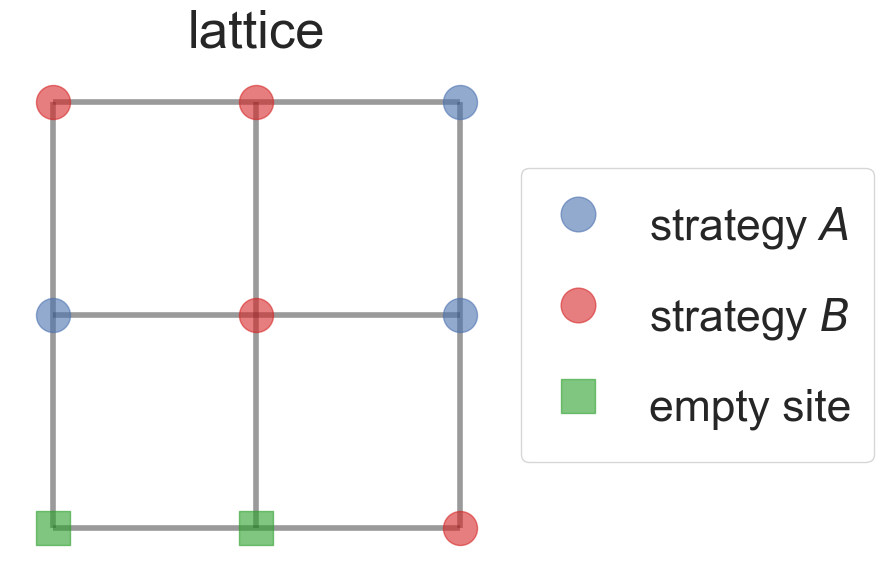

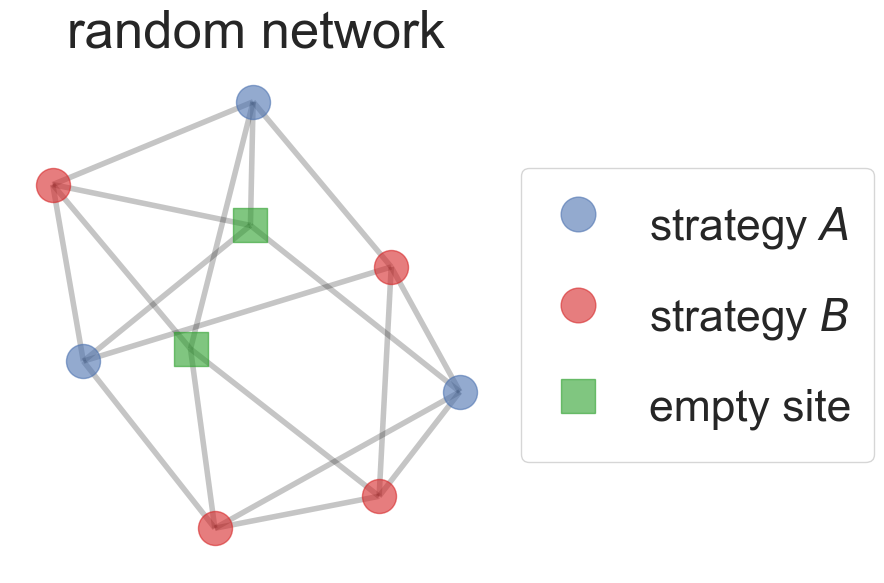

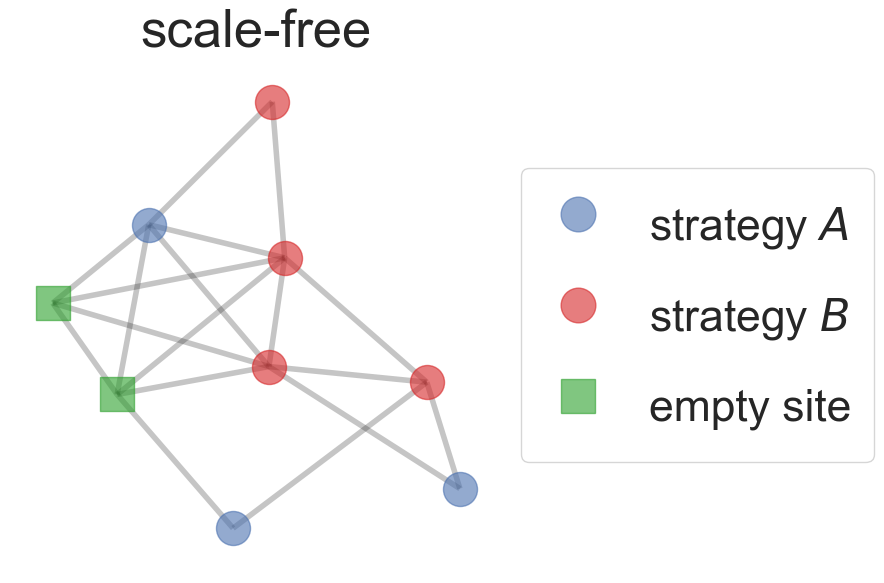

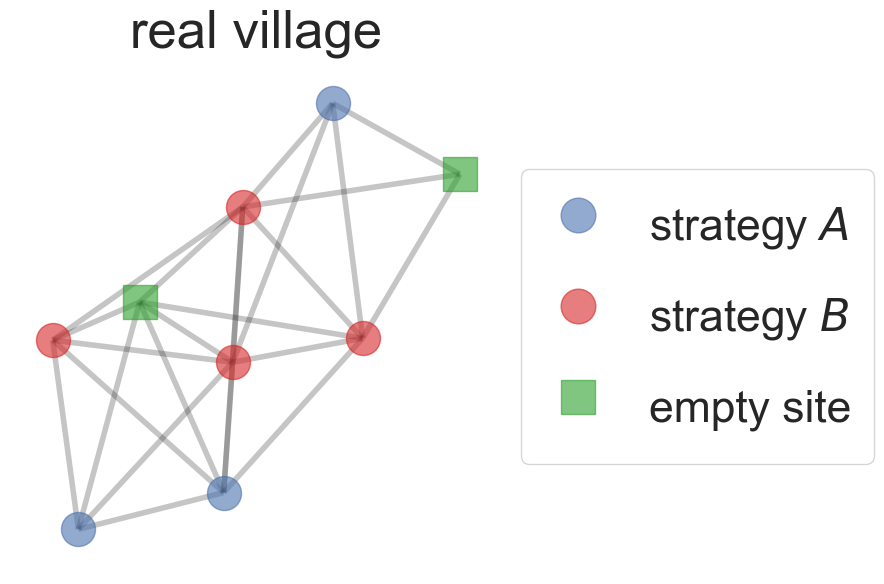

In [57]:
for name in ['lattice', 'random', 'scalefree', 'village']:
    H, A = initilization_network(L = 3, W = 3, p_e_sub = 1/5, tag = 1, graph = name, palette = palette_1, alpha = 0.6, 
                                 fsize = (9, 6), fs = 38, plotting = True)

In [59]:
def initilization_lattice(L = 10, p_e_sub = 1/5):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    '''
    # status
    N_e_sub = L*L
    N_sub = int(N_e_sub*(1 - p_e_sub))
    H = np.concatenate([np.random.randint(1, 3, int(L**2*(1 - p_e_sub))), # random integers of 1 or 2
                        np.random.randint(0, 1, L**2 - int(L**2*(1 - p_e_sub)))]) # integers of 0 (empty site)

    random.shuffle(H)
    G = nx.grid_2d_graph(L, L, periodic = True)
    for j, item in enumerate(G.nodes):
        G.nodes[item]['state'] = H[j]
    G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    # !!! !!! !!! !!! all the non-empty sites are connected !!! !!! !!! !!!
    while not nx.is_connected(G_AB):
        random.shuffle(H)
        for j, item in enumerate(G.nodes):
            G.nodes[item]['state'] = H[j]
        G_AB = G.subgraph([j for j, item in G.nodes(data = True) if item['state'] != 0])
    
    A = nx.to_numpy_array(G)
    return H, A

def data_death_birth(L = 10, p_e_sub = 1/5, S_sub = -1, T_sub = 2, beta_sub = 0.005, v_sub = 0.001):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    H: strategy distribution of the lattice
    A: adjacency matrix
    S_sub: payoff of cooperation against defection
    T_sub: payoff of defection against cooperation
    beta_sub: strength of selection
    v_sub: probability of mutation
    '''
    # parameters
    R_sub = 1
    P_sub = 0
    alpha_A_sub = alpha_B_sub = 0
    N_e_sub = L*L
    N_sub = int(N_e_sub*(1 - p_e_sub))
    # structure
    H0, A = initilization_lattice(L, p_e_sub)
    H = H0.copy()
    indices_AB = np.where(H0 != 0)[0]
    # payoff
    M = np.array([[0, 0, 0], [alpha_A_sub, R_sub, S_sub], [alpha_B_sub, T_sub, P_sub]])
    # fitness
    def fitness(l):
        neighbors = np.where(A[l] == 1)[0]
        return np.exp(beta_sub*np.sum([M[H[l]][H[nb]] for nb in neighbors]))
    # evolution
    t = 0 # generation
    T = int(1e6)
    abundances = np.zeros((2, T))
    while t < T:
        abundances[0, t] = np.sum(H == 1)
        abundances[1, t] = np.sum(H == 2)
        # focal individual
        j = random.choice(indices_AB)
        neighbors = np.where(A[j] == 1)[0]
        fitness_A = np.sum([fitness(l) if H[l] == 1 else 0 for l in neighbors]) 
        fitness_B = np.sum([fitness(l) if H[l] == 2 else 0 for l in neighbors])
        if random.uniform(0, 1) < v_sub: # mutation
            H[j] = 1 + int(random.uniform(0, 1) > 1/2)
        else: # no mutation
            if random.uniform(0, 1) < fitness_A/(fitness_A + fitness_B):
                H[j] = 1
            else:
                H[j] = 2
        t += 1
    abundances = abundances/N_sub
    return abundances

def figure_death_birth(abundances, L = 10, p_e_sub = 1/5, beta_sub = 0.005, v_sub = 0.001, palette = palette_0, alpha = 0.6,
                       fsize = (8, 6), fs = 20):
    '''
    L: length of lattice
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    v_sub: probability of mutation
    fsize: figure size
    fs: font size
    '''
    fig, ax = plt.subplots(figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    labels = [r'$A$', r'$B$']
    # use a known color palette
    ts = np.linspace(0, np.shape(abundances)[1] - 1, np.shape(abundances)[1])
    # ax.stackplot(ts[::1000], abundances[:, ::1000], colors = palette[1: ], alpha = 0.6, edgecolor = 'none', 
                 # labels = labels)
    ax.fill_between(ts[::1000], abundances[0, ::1000], color = palette[1], alpha = alpha, label = r'$\lambda_A$')
    ax.fill_between(ts[::1000], abundances[0, ::1000], abundances[0, ::1000] + abundances[1, ::1000], color = palette[2], alpha = alpha, 
                    label = r'$\lambda_B$', where = abundances[0, ::1000] + abundances[1, ::1000] > abundances[0, ::1000])
    ax.plot(ts[::1000], abundances[0, ::1000], color = 'white', alpha = 1, linewidth = 2)
    # ax.set_title('', fontsize = fs)
    ax.set_xlim([-1e4, 1e6 + 1e4])
    ax.set_xlabel(r'$t$', fontsize = fs - 2)
    ax.set_ylabel('abundance', fontsize = fs - 2)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [labels[0], r'$0$', r'$200k$', r'$400k$', r'$600k$', r'$800k$', r'$1m$']
    labels = [labels[0], r'$0$', r'$2e5$', r'$4e5$', r'$6e5$', r'$8e5$', r'$1e6$']
    ax.set_xticklabels(labels)
    plt.xticks(fontsize = fs - 4)
    plt.yticks(fontsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 6)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 6)
    ax.legend(ncol = 1, loc = 'upper right', fancybox = True, fontsize = fs - 6)
    plt.savefig(_Figure_PATH_ + 'fig1X.png', dpi = 600, facecolor = fig.get_facecolor(), edgecolor = 'none', 
                bbox_inches = 'tight')

In [61]:
stime = time.time()
abundances = data_death_birth()
etime = time.time()
print(str(round((etime - stime)/60)) + ' minutes')

1 minutes


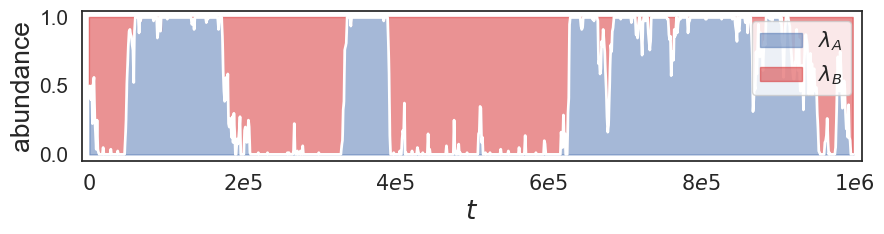

In [63]:
figure_death_birth(abundances, L = 10, p_e_sub = 1/5, beta_sub = 0.005, v_sub = 0.001, palette = palette_1, alpha = 0.5,
                   fsize = (9, 2.5), fs = 21)

### Equations (19 - 26)

In [65]:
# substitutions
q_AA_sub = p_A + 1/(k - 1) - p_A/((k - 1)*(1 - p_e)) # Equation (19)
q_BB_sub = p_B + 1/(k - 1) - p_B/((k - 1)*(1 - p_e)) # Equation (20)
q_BA_sub = p_B - p_B/((k - 1)*(1 - p_e)) # Equation (21)
q_AB_sub = p_A - p_A/((k - 1)*(1 - p_e)) # Equation (22)
pi_AA_sub = R + (k - 1)*(q_AA*R + q_BA*S + p_e*alpha_A) # Equation (23)
pi_BA_sub = T + (k - 1)*(q_AB*T + q_BB*P + p_e*alpha_B) # Equation (24)
pi_AB_sub = S + (k - 1)*(q_AA*R + q_BA*S + p_e*alpha_A)
pi_BB_sub = P + (k - 1)*(q_AB*T + q_BB*P + p_e*alpha_B)

n_AA, n_BA, n_AB, n_BB = k*q_AA, k*q_BA, k*q_AB, k*q_BB # number of neighbors
f_AA, f_BA, f_AB, f_BB = exp(beta*pi_AA), exp(beta*pi_BA), exp(beta*pi_AB), exp(beta*pi_BB) # fitness
T_A_backward = p_A*n_BA*f_BA/(n_AA*f_AA + n_BA*f_BA) # Equation (25)
T_A_forward = p_B*n_AB*f_AB/(n_AB*f_AB + n_BB*f_BB) # Equation (26)

### Equation (29): $\rho_A > 1/N$

In [68]:
# p_AB = p_A*q_BA = p_B*q_AB, 1 = p_A + p_B + p_e = q_AA + q_BA + p_e = q_AB + q_BB + p_e
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({p_A: p_AB/q_BA, p_B: p_AB/q_AB, q_BA: 1 - q_AA - p_e, q_AB: 1 - q_BB - p_e}))
remainder = factor((1 - ratio)*(1 - p_e)/beta)
collect(collect(remainder, q_AA), q_BB)

### Equation (30): $\rho_A > \rho_B$

In [71]:
ratio = factor(T_A_forward/T_A_backward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({p_A: p_AB/q_BA, p_B: p_AB/q_AB, q_BA: 1 - q_AA - p_e, q_AB: 1 - q_BB - p_e}))
remainder = factor((ratio - 1)*(1 - p_e)/beta)
collect(collect(remainder, q_AA), q_BB)

## From Discrete to Continuous

In [74]:
target = factor(remainder.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, 
                                q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
target = factor(target.subs({p_A: (1 - p_e)*i/N, p_B: (1 - p_e)*(N - i)/N}))
target = factor(target.subs({i: N*x}))

### Equation (2): $\rho_A > 1/N$

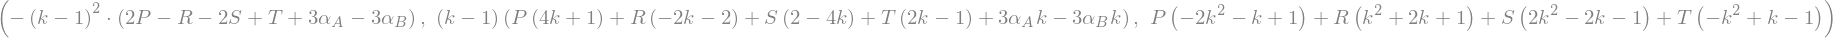

In [77]:
flag1 = fraction(factor(integrate(integrate(target.subs({x: y}), (y, 0, x)), (x, 0, 1))))[0]
flag12, flag11, flag10 = [factor(flag1.coeff(p_e, i)) for i in [2, 1, 0]]
flag12 = collect(collect(collect(collect(flag12, R), S), T), P)
flag11 = collect(collect(collect(collect(flag11, R), S), T), P)
flag10 = collect(collect(collect(collect(flag10, R), S), T), P)
flag12, flag11, flag10

### Equations (3 - 4): $\rho_A > \rho_B$

In [80]:
flag2 = factor_list(fraction(factor(integrate(target, (x, 0, 1))))[0])[1][1][0] # the first factor is always positive
flag21, flag20 = [factor(flag2.coeff(p_e, i)) for i in [1, 0]]
flag20 = collect(collect(collect(collect(flag20, R), S), T), P)
flag21, flag20

In [81]:
# alpha_A = alpha_B = 0
flag12, flag11, flag10 = [flag.subs({alpha_A: 0, alpha_B: 0}) for flag in [flag12, flag11, flag10]]
flag21, flag20 = [flag.subs({alpha_A: 0, alpha_B: 0}) for flag in [flag21, flag20]]

### Equations (7 - 8)

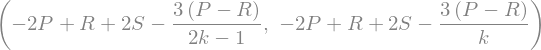

In [85]:
# open upwards or downwards: factor(flag12/(k - 1)**2)
# derivative at p_e = 0 positive or negative: factor(flag11/(k - 1))
tag_site_left = factor(solve(factor(flag11/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
# value at p_e = 1 positive or negative: factor((flag12 + flag11)/(k - 1))
tag_site_mid = factor(solve(factor((flag12 + flag11)/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
tag_site_left, tag_site_mid

### Equations (10)

In [88]:
# derivative at p_e = 1 positive or negative: factor((2*flag12 + flag11)/(k - 1))
tag_site_right = factor(solve(factor((2*flag12 + flag11)/(k - 1)), T)[0] - (R + 2*S - 2*P)) + (R + 2*S - 2*P)
tag_site_right

### Equation (13)

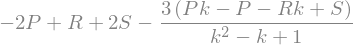

In [91]:
# in the absence of empty sites
tag_spatial = (R + 2*S - 2*P) + factor(solve(flag10, T)[0] - (R + 2*S - 2*P))
tag_spatial

### Intersection Point 
> of spatial structure and site dilution

### Equation (14)

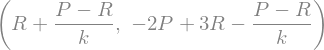

In [95]:
S_int = factor(solve(tag_spatial - tag_site_mid, S)[0] - R) + R
T_int = factor(tag_spatial.subs({S: S_int}) - 3*R + 2*P) + 3*R - 2*P
S_int, T_int

### Equation (15)

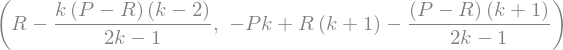

In [98]:
S_into = factor(solve(tag_spatial - tag_site_left, S)[0] - R) + R
T_into = factor(tag_spatial.subs({S: S_into}) - (k + 1)*R + k*P) + (k + 1)*R - k*P
S_into, T_into

## 🥞🥞🥞 Figure 2: Dual impact of site dilution 🥞🥞🥞

In [101]:
def figure_dual_impact(R_sub, P_sub, k_sub, alpha_A_sub = 0, alpha_B_sub = 0, 
                       lw = 2, ms = 10, fsize = (6, 6), fs = 18):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub}), (y, 0, x)), (x, 0, 1))
    flag1 = fraction(factor(flag1))[0] # !!! does not change the result !!!
    flag12, flag11, flag10 = [factor(flag1.coeff(p_e, i)) for i in [2, 1, 0]]
    lam_site_negative = lambdify([S], solve(factor(flag11/(k - 1)), T)[0]) # Equation (7)
    lam_site_positive = lambdify([S], solve(factor((flag12 + flag11)/(k - 1)), T)[0]) # Equation (8)
    lam_spatial = lambdify([S], solve(flag10, T)[0]) # Equation (12-13)
    # intersection point of spatial structure and site dilution
    S_int = solve(solve(flag10, T)[0] - solve(factor((flag12 + flag11)/(k - 1)), T)[0], S)[0]
    
    S_subs = np.linspace(-1, 1, 201)
    S_min = -1
    T_max = 2
    
    a = [0.25, 0.4, 0.6, 0.8] # transparency
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw = {'width_ratios': [2, 1, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    # main figure
    ax0.plot(S_subs, lam_spatial(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_site_negative(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_site_positive(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.fill_between(S_subs, lam_site_negative(S_subs), color = colors[0], alpha = a[1])
    ax0.fill_between(S_subs, lam_site_negative(S_subs), lam_site_positive(S_subs), color = colors[2], alpha = a[1])
    ax0.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), color = colors[1], alpha = a[1])
    ax0.fill_between(S_subs, lam_spatial(S_subs), 2, color = colors[3], alpha = a[1])
    # prisoner's dilemma
    points = [[-1, 1], [0, 1], [0, 4], [-1, 4]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # snowdrift game
    points = [[0, 1], [1, 1], [1, 4], [0, 4]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # stag-hunt game
    points = [[-1, 0], [0, 0], [0, 1], [-1, 1]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # boundaries
    line = plt.Line2D((S_min, R_sub), (R_sub, R_sub), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[2])
    ax0.add_line(line)
    line = plt.Line2D((P_sub, P_sub), (P_sub, T_max), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[2])
    ax0.add_line(line)
    # notations and arrows
    ax0.text(-0.75, 1.775, 'spatial effect', fontsize = fs - 2)
    ax0.text(-0.5, 0.275, 'site dilution effect', fontsize = fs - 2)
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8', color = 'black')
    arrow_spatial = mpatches.FancyArrowPatch((-0.25, lam_spatial(-0.25)), (-0.5, 1.7), 
                                             connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_spatial)
    arrow_site_negative = mpatches.FancyArrowPatch((-0.325, lam_site_negative(-0.325)), (-0.225, 0.4), 
                                                   connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_site_negative)
    arrow_site_positive = mpatches.FancyArrowPatch((-0.5, lam_site_positive(-0.5)), (-0.4, 0.4), 
                                                   connectionstyle = "arc3, rad = -0.25", **kw)
    ax0.add_patch(arrow_site_positive)
    
    ax0.set_xlabel(r'$S$', fontsize = fs - 2)
    ax0.set_ylabel(r'$T$', fontsize = fs - 2)
    ax0.set_xlim([-1, 1])
    ax0.set_ylim([0, 2])
    ax0.set_xticks(np.arange(-1, 1.5, 0.5))
    ax0.set_yticks(np.arange(0, 2.5, 0.5))
    ax0.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax0.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax0.set_aspect('equal')
    
    # sub figure: donation game
    S_subs = np.linspace(0.7, 0.8, 201)
    ax1.plot(S_subs, lam_spatial(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.plot(S_subs, lam_site_negative(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.plot(S_subs, lam_site_positive(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax1.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), where = (S_subs < S_int), 
                     color = colors[1], alpha = a[2])
    ax1.fill_between(S_subs, lam_site_positive(S_subs), lam_spatial(S_subs), where = (S_subs > S_int), 
                     color = colors[4], alpha = a[2])
    ax1.fill_between(S_subs, np.max([lam_spatial(S_subs), lam_site_positive(S_subs)], axis = 0), 3.5, 
                     color = colors[3], alpha = a[1])
    ax1.fill_between(S_subs, np.min([lam_spatial(S_subs), lam_site_positive(S_subs)], axis = 0), 
                     color = colors[2], alpha = a[1])
    ax1.plot(S_int, lam_spatial(S_int), c = 'black', marker = 'o', markersize = ms, zorder = 600)
    points = [[0.74, 3.23], [0.76, 3.23], [0.76, 3.27], [0.74, 3.27]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax1.add_patch(square)
    ax1.set_xlabel('', fontsize = fs - 2)
    ax1.set_ylabel('', fontsize = fs - 2)
    ax1.set_xlim([0.74, 0.76])
    ax1.set_ylim([3.23, 3.27])
    ax1.set_xticks(np.arange(0.74, 0.76, 0.01))
    ax1.set_yticks(np.arange(3.23, 3.27, 0.01))
    ax1.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax1.set_aspect('equal')
    
    # sub figure: legend
    ax2.axis('off')
    patch_pd = mpatches.Patch(facecolor = colors[0], hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "Prisoner's Dilemma (upper left quadrant)")
    patch_sd = mpatches.Patch(facecolor = colors[0], hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "snowdrift game (upper right quadrant)")
    patch_sh = mpatches.Patch(facecolor = colors[0], hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "stag-hunt game (lower left quadrant)")
    patch0 = mpatches.Patch(color = colors[0], alpha = a[2], linewidth = 0, 
                            label = 'site dilution ' + r'$(-)$' + ', spatial structure ' + r'$(+)$')
    patch1 = mpatches.Patch(color = colors[2], alpha = a[2], linewidth = 0, 
                            label = 'site dilution ' + r'$(\pm)$' + ', spatial structure ' + r'$(+)$')
    patch2 = mpatches.Patch(color = colors[1], alpha = a[2], linewidth = 0, 
                            label = 'site dilution ' + r'$(+)$' + ', spatial structure ' + r'$(+)$')
    patch3 = mpatches.Patch(color = colors[3], alpha = a[2], linewidth = 0, 
                            label = 'site dilution ' + r'$(+)$' + ', spatial structure ' + r'$(-)$')
    patch4 = mpatches.Patch(color = colors[4], alpha = a[2], linewidth = 0, 
                            label = 'site dilution ' + r'$(\pm)$' + ', spatial structure ' + r'$(-)$')
    ax2.legend(handles = [patch_pd, patch_sd, patch_sh, patch0, patch1, patch2, patch3, patch4], 
               handleheight = 2.25, handlelength = 1.8, 
               loc = 'center', ncol = 1, bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 6)
    
    plt.savefig(_Figure_PATH_ + 'fig2.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

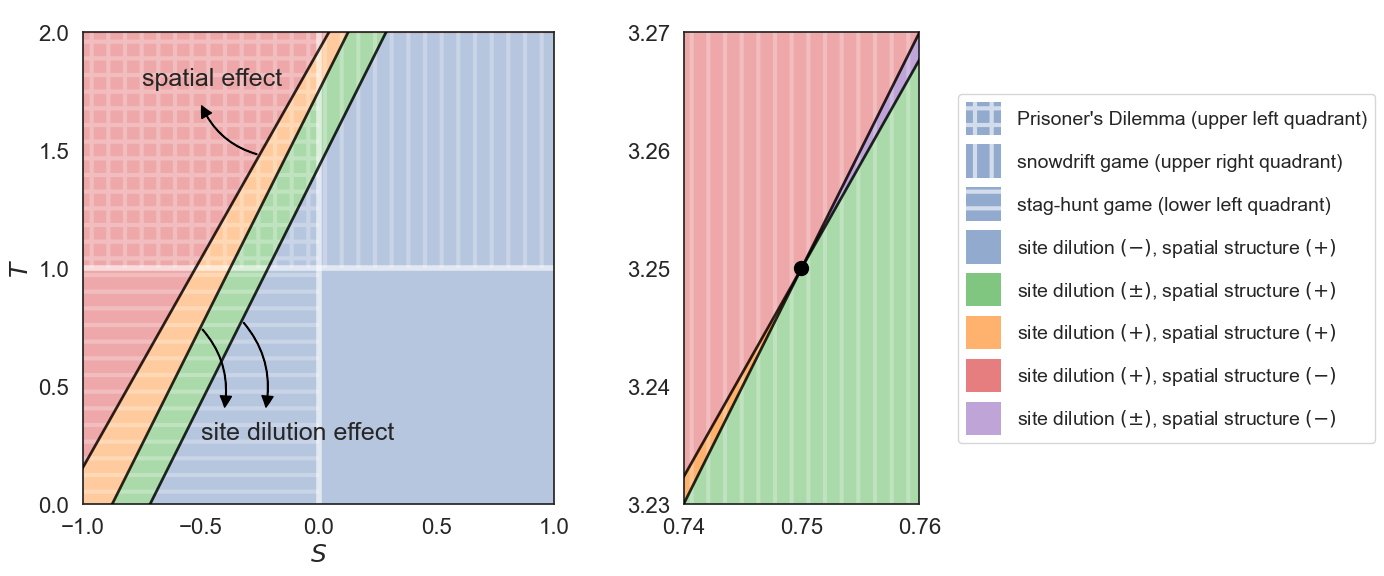

In [103]:
figure_dual_impact(R_sub = 1, P_sub = 0, k_sub = 4, lw = 2, ms = 10, fsize = (14, 6), fs = 20)

### Equation (16)

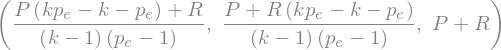

In [106]:
# the intersection point of rho_A = 1/N and rho_A = rho_B
eq_int = factor(flag1.subs({alpha_A: 0, alpha_B: 0}).subs({T: solve(flag2.subs({alpha_A: 0, alpha_B: 0}), T)[0]}))
eq_int = factor_list(fraction(eq_int)[0])[1][2][0]
S_int = factor(solve(eq_int, S)[0])
T_int = factor(solve(flag2.subs({alpha_A: 0, alpha_B: 0}), T)[0].subs({S: S_int}))
collect(collect(S_int, R), P), collect(collect(T_int, R), P), factor(S_int + T_int)

### Equation (17)

In [109]:
flag21.subs({T: R + S - P}), flag20, factor(flag20.subs({T: R + S - P})), factor(flag21 + flag20)

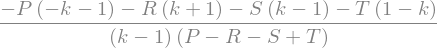

In [111]:
-flag20/flag21

### Whether the region of $\rho_A > 1/N$ is above or below the critical line of $\rho_A = 1/N$?

> below

In [114]:
coeff_T = flag1.coeff(T, 1) # a quadratic function of p_e: opening downward
factor(coeff_T.coeff(p_e, 1)**2 - 4*coeff_T.coeff(p_e, 2)*coeff_T.coeff(p_e, 0)) # b^2 - 4ac < 0

### Whether the region of $\rho_B > 1/N$ is to the left or right of the critical line of $\rho_B = 1/N$?

> left

### Whether the region of $\rho_A > \rho_B$ is above or below the critical line of $\rho_A = \rho_B$?

> below

In [118]:
factor(flag2.coeff(T, 1)) # a linear function of p_e

## 🥞🥞🥞 Figure 3: Comparison of fixation probabilities 🥞🥞🥞

In [121]:
def figure_fixation(R_sub = 1, P_sub = 0, k_sub = 4, p_e_sub = 1/5, alpha_A_sub = 0, alpha_B_sub = 0, 
                    lw = 2, ms = 10, fsize = (8, 6), fs = 20):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    # fixation probability of A
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub}), (y, 0, x)), (x, 0, 1))
    
    lam_A = lambdify([S], solve(flag1, T)[0]) # below: > 1/N, above: < 1/N
    # fixation probability of B
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_B_sub, alpha_B: alpha_A_sub, 
                                             R: P_sub, P: R_sub, k: k_sub, p_e: p_e_sub}), (y, 0, x)), (x, 0, 1))
    lam_B = lambdify([T], solve(flag1, S)[0]) # right: < 1/N, left: > 1/N
    # rho_A/rho_B
    flag2 = integrate(target.subs({alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                   R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub}), (x, 0, 1))
    lam_C = lambdify([S], solve(flag2, T)[0]) # below: rho_A > rho_B, above: rho_A < rho_B
    # intersection point of rho_A = rho_B = 1/N: Equation (26)
    S_int = (-R + (k*(1 - p_e) + p_e)*P)/((k - 1)*(1 - p_e))
    T_int = (-P + (k*(1 - p_e) + p_e)*R)/((k - 1)*(1 - p_e))
    S_int = S_int.subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub})
    T_int = T_int.subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub})
    
    if p_e_sub == 1/5:
        S_min, T_max = -1, 2
    elif p_e_sub == 4/5:
        S_min, T_max = -4, 5
    else:
        S_min, T_max = -4, 5
    S_subs = np.linspace(S_min, R_sub, 501)
    
    a = [0.2, 0.4, 0.6, 0.8]
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [3, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    ax0.plot(S_subs, lam_A(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_B(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, lam_C(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    if p_e_sub == 1/5:
        ax0.fill_between(S_subs, P_sub, np.min([lam_A(S_subs), lam_B(S_subs)], axis = 0), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, np.max([lam_A(S_subs), lam_B(S_subs)], axis = 0), T_max, 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, lam_B(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs > S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs < S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, lam_B(S_subs), lam_C(S_subs), where = (S_subs < S_int), 
                         color = colors[6], alpha = a[2])
    elif p_e_sub == 4/5:
        ax0.fill_between(S_subs, P_sub, np.min([lam_A(S_subs), lam_B(S_subs)], axis = 0), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, np.max([lam_A(S_subs), lam_B(S_subs)], axis = 0), T_max, 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_B(S_subs), where = (S_subs < S_int), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs < S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_B(S_subs), where = (S_subs > S_int), 
                         color = colors[6], alpha = a[2])
    else:
        ax0.fill_between(S_subs, lam_B(S_subs), lam_A(S_subs), where = (S_subs > S_int), 
                         color = colors[0], alpha = a[1])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_B(S_subs), where = (S_subs < S_int), 
                         color = colors[3], alpha = a[1])
        ax0.fill_between(S_subs, P_sub, np.min([lam_B(S_subs), lam_C(S_subs)], axis = 0), 
                         color = colors[2], alpha = a[2])
        ax0.fill_between(S_subs, lam_C(S_subs), lam_A(S_subs), where = (S_subs < S_int), 
                         color = colors[4], alpha = a[2])
        ax0.fill_between(S_subs, lam_A(S_subs), lam_C(S_subs), where = (S_subs > S_int), 
                         color = colors[1], alpha = a[2])
        ax0.fill_between(S_subs, np.max([lam_B(S_subs), lam_C(S_subs)], axis = 0), T_max, 
                         color = colors[6], alpha = a[2])
    
    # intersection point
    ax0.plot(S_int, T_int, c = 'black', marker = 'o', markersize = ms, zorder = 600)
    
    # prisoner's dilemma
    points = [[S_min, R_sub], [P_sub, R_sub], [P_sub, T_max], [S_min, T_max]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # snowdrift game
    points = [[P_sub, R_sub], [R_sub, R_sub], [R_sub, T_max], [P_sub, T_max]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # stag-hunt game
    points = [[S_min, P_sub], [P_sub, P_sub], [P_sub, R_sub], [S_min, R_sub]]
    square = plt.Polygon(points, facecolor = 'none', hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[0])
    ax0.add_patch(square)
    # donation game
    line = plt.Line2D((S_min, P_sub), (T_max, R_sub), c = 'black', lw = lw, ls = '--', 
                      marker = '.', markersize = 0, alpha = a[3], zorder = 500)
    ax0.add_line(line)
    # boundaries
    line = plt.Line2D((S_min, R_sub), (R_sub, R_sub), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[1])
    ax0.add_line(line)
    line = plt.Line2D((P_sub, P_sub), (P_sub, T_max), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[1])
    ax0.add_line(line)
    
    # notations and arrows
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8', color = 'black')
    if p_e_sub == 1/5:
        ax0.text(-0.75, 1.8, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(0.3, 1.575, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-0.75, 0.525, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((-0.35, lam_A(-0.35)), (-0.5, 1.7), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        arrow_B = mpatches.FancyArrowPatch((0.2, lam_B(0.2)), (0.45, 1.7), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        arrow_C = mpatches.FancyArrowPatch((-0.9, lam_C(-0.9)), (-0.6, 0.65), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
    elif p_e_sub == 4/5:
        ax0.text(-1.1, 2.2, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(-2.25, 4.25, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-2.35, 0.3, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((-0.8, lam_A(-0.8)), (-0.6, 2.5), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        arrow_B = mpatches.FancyArrowPatch((-1.2, lam_B(-1.2)), (-1.5, 4.1), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        arrow_C = mpatches.FancyArrowPatch((-2.5, lam_C(-2.5)), (-2, 0.6), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
    else:
        ax0.text(-1.25, 2.8, r'$\rho_A = 1/N$', fontsize = fs - 2)
        ax0.text(-2.5, 1.85, r'$\rho_B = 1/N$', fontsize = fs - 2)
        ax0.text(-2.4, 4.45, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_A = mpatches.FancyArrowPatch((-0.3, lam_A(-0.3)), (-0.6, 3.1), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        arrow_B = mpatches.FancyArrowPatch((-2.9, lam_B(-2.9)), (-2.1, 1.7), 
                                           connectionstyle = "arc3, rad = 0.25", **kw, zorder = 500)
        arrow_C = mpatches.FancyArrowPatch((-3, lam_C(-3)), (-2, 4.75), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
    ax0.add_patch(arrow_A)
    ax0.add_patch(arrow_B)
    ax0.add_patch(arrow_C)
    
    notations = {1/5: r'$1/5$', 4/5: r'$4/5$', 9/10: r'$9/10$'}
    ax0.set_title(r'$p_e = $' + notations[p_e_sub], fontsize = fs, y = 1.01)
    ax0.set_xlabel(r'$S$', fontsize = fs - 2)
    ax0.set_ylabel(r'$T$', fontsize = fs - 2)
    ax0.set_xlim([S_min, R_sub])
    ax0.set_ylim([P_sub, T_max])
    ax0.set_xticks(np.arange(S_min, R_sub + 0.5, (lambda x: 0.5 if x < 1/5 else 1)(p_e_sub)))
    ax0.set_yticks(np.arange(P_sub, T_max + 0.5, (lambda x: 0.5 if x < 1/5 else 1)(p_e_sub)))
    ax0.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax0.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax0.set_aspect('equal')

    # sub figure: legend
    ax1.axis('off')
    patch_pd = mpatches.Patch(facecolor = colors[0], hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "PD (upper left quadrant)")
    patch_sd = mpatches.Patch(facecolor = colors[0], hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "SD (upper right quadrant)")
    patch_sh = mpatches.Patch(facecolor = colors[0], hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "SH (lower left quadrant)")
    patch0 = mpatches.Patch(color = colors[2], alpha = a[2], linewidth = 0, label = r'$\rho_A > \rho_B > 1/N$')
    patch1 = mpatches.Patch(color = colors[0], alpha = a[2], linewidth = 0, label = r'$\rho_A > 1/N > \rho_B$')
    patch2 = mpatches.Patch(color = colors[1], alpha = a[2], linewidth = 0, label = r'$1/N > \rho_A > \rho_B$')
    patch3 = mpatches.Patch(color = colors[6], alpha = a[2], linewidth = 0, label = r'$1/N > \rho_B > \rho_A$')
    patch4 = mpatches.Patch(color = colors[3], alpha = a[2], linewidth = 0, label = r'$\rho_B > 1/N > \rho_A$')
    patch5 = mpatches.Patch(color = colors[4], alpha = a[2], linewidth = 0, label = r'$\rho_B > \rho_A$ > 1/N')
    ax1.legend(handles = [patch_pd, patch_sd, patch_sh, patch0, patch1, patch2, patch3, patch4, patch5], 
               handleheight = 2.25, handlelength = 1.8, 
               loc = 'center', ncol = 1, bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 6)
    plt.savefig(_Figure_PATH_ + 'fig3_' + str(int(p_e_sub*10)) + '.png', dpi = 400, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

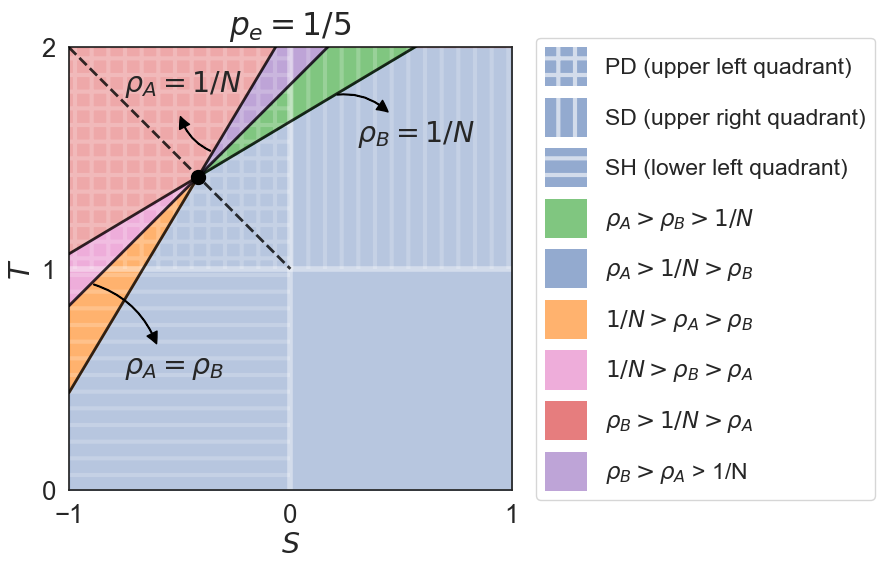

In [123]:
figure_fixation(fsize = (9, 6), fs = 22.5)

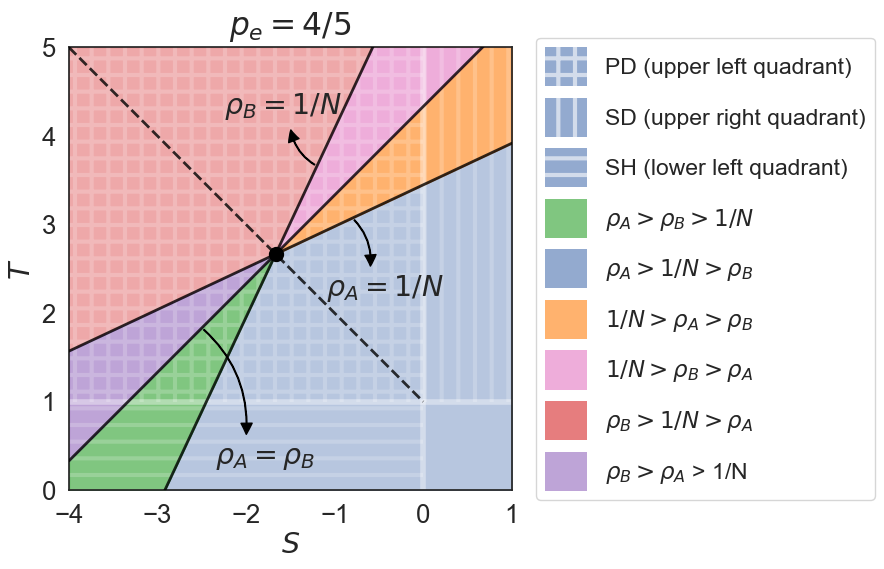

In [125]:
figure_fixation(p_e_sub = 4/5, fsize = (9, 6), fs = 22.5)

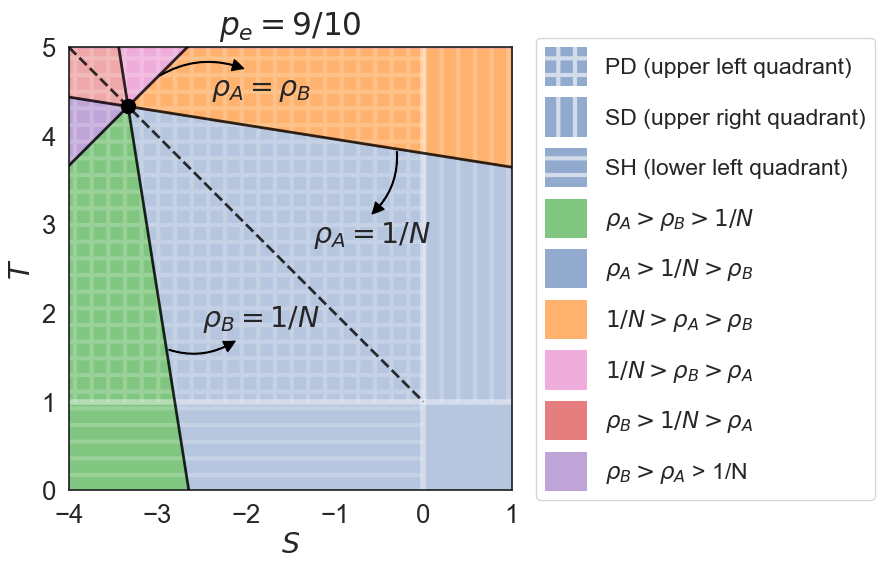

In [127]:
figure_fixation(p_e_sub = 9/10, fsize = (9, 6), fs = 22.5)

## 🥞🥞🥞 Figure 4: Site dilution can boost or hinder the fixation of a single A 🥞🥞🥞

In [130]:
def figure_fixation_A(R_sub = 1, P_sub = 0, k_sub = 4, S_subs = [0], 
                      alpha_A_sub = 0, alpha_B_sub = 0, dg_sub = u, 
                      lw = 2, ms = 10, fsize = (6, 6), fs = 20):
    '''
    lw: line width
    ms: marker size
    fsize: figure size
    fs: font size
    '''
    # fixation probability of A
    flag1 = integrate(integrate(target.subs({x: y, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, 
                                             R: R_sub, P: P_sub, k: k_sub}), (y, 0, x)), (x, 0, 1))
    flag1 = fraction(factor(flag1))[0] # !!! does not change the result !!!
    
    T_max, u_max = 5, 5 # T_max = 6
    p_e_subs = np.linspace(0, 1, 2001)
    T_subs = np.linspace(0, T_max, 2001)
    u_subs = np.linspace(0, u_max, 2001)
    z, w = np.meshgrid(p_e_subs, T_subs)
    z_dg, w_dg = np.meshgrid(p_e_subs, u_subs)
    
    a = [0.2, 0.4, 0.6, 0.8]
    # fig, axes = plt.subplots(nrows = 2, ncols = 2, 
                             # gridspec_kw = {'width_ratios': [1]*2, 'height_ratios': [1]*2}, figsize = fsize)
    fig, axes = plt.subplots(nrows = 1, ncols = 4, 
                             gridspec_kw = {'width_ratios': [1]*4, 'height_ratios': [1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')
    
    # rho_A > 1/N
    # gain from site dilusion
    notations = [r'$-3/2$', r'$-1/2$', r'$1/2$'] # r'$2$'
    for j, S_sub in enumerate(S_subs):
        # ax = axes[int(j/2)][j%2]
        ax = axes[j]
        lam_gain = lambdify([p_e, T], flag1.subs({S: S_sub}))
        ax.contourf(z, w, (lam_gain(z, w) > 0).astype(int), [0.99999, 1.00001], 
                    cmap = mcolors.ListedColormap([colors[0], colors[0]]), alpha = a[1])
        ax.set_title(r'$S = $' + notations[j], fontsize = fs)
        ax.set_xlabel(r'$p_e$', fontsize = fs - 2)
        ax.set_ylabel(r'$T$', fontsize = fs - 2)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, T_max])
        ax.set_xticks(np.arange(0, 1 + 0.2, 0.2))
        ax.set_yticks(np.arange(0, T_max + 1, 1))
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    # donation game
    j+= 1
    # ax = axes[int(j/2)][j%2]
    ax = axes[j]
    lam_gain = lambdify([p_e, u], flag1.subs({S: -dg_sub, T: 1 + dg_sub}))
    points = [[0, 0], [1, 0], [1, u_max], [0, u_max]]
    ax.contourf(z_dg, w_dg, (lam_gain(z_dg, w_dg) > 0).astype(int), [0.99999, 1.00001],  
                cmap = mcolors.ListedColormap([colors[0], colors[0]]), alpha = a[1])
    cs = ax.contourf(z_dg, w_dg, (lam_gain(z_dg, w_dg) > 0).astype(int), 
                     colors = 'none', hatches = ['+'], extend = 'lower')
    cs.collections[0].set_facecolor('none')
    cs.collections[0].set_edgecolor('white')
    cs.collections[0].set_linewidth(0)
    cs.collections[-1].set_facecolor('none')
    cs.collections[-1].set_edgecolor('white')
    cs.collections[-1].set_linewidth(0)
    
    ax.set_title(r'$S = -u, T = 1 + u$', fontsize = fs)
    ax.set_xlabel(r'$p_e$', fontsize = fs - 2)
    ax.set_ylabel(r'$u$', fontsize = fs - 2)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, u_max])
    ax.set_xticks(np.arange(0, 1 + 0.2, 0.2))
    ax.set_yticks(np.arange(0, u_max + 1, 1))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    
    plt.savefig(_Figure_PATH_ + 'fig4.png', dpi = 600, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

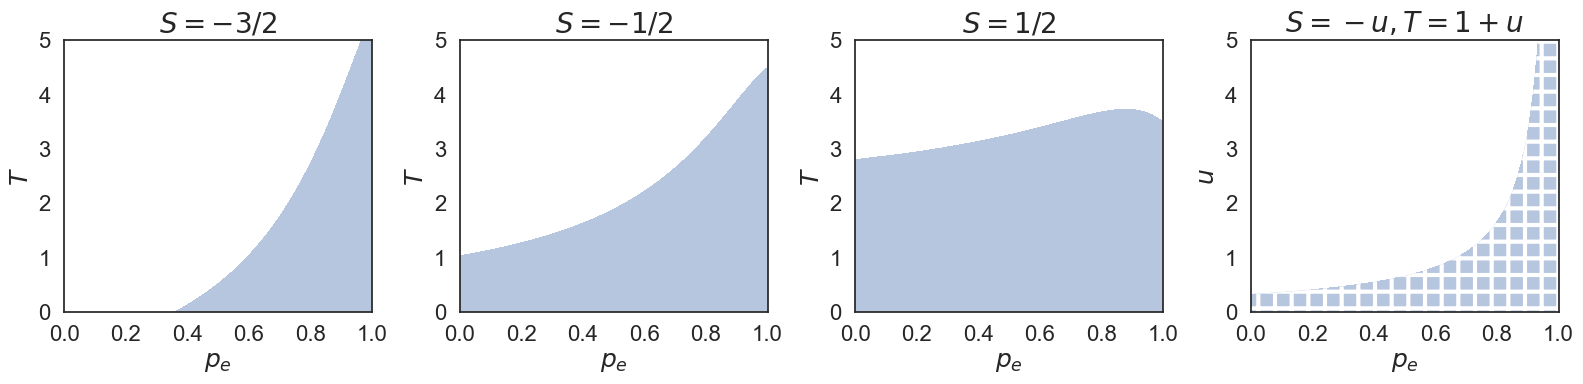

In [132]:
figure_fixation_A(S_subs = [-3/2, -1/2, 1/2], fsize = (16, 4), fs = 20)

## 🍑🍑🍑 Agent-based simulation 🍑🍑🍑

> use notations $j$ and $l$ for indices to avoid conflicting with $i$ and $k$

In [135]:
def fixation_sim(L, W, p_e_sub, S_sub, T_sub, beta_sub, tag, graph = 'lattice'):
    '''
    L: length of lattice
    W: width of the lattice
    H: strategy distribution of the lattice
    A: adjacency matrix
    p_e_sub: fraction of empty sizes
    beta_sub: strength of selection
    tag: 1 (A) or 2 (B)
    graph: 'lattice', 'regular', ‘scalefree’, or 'village'
    '''
    # parameters
    R_sub = 1
    P_sub = 0
    alpha_A_sub = alpha_B_sub = 0
    N_e_sub = L*W
    N_sub = int(N_e_sub*(1 - p_e_sub))
    # structure
    H0, A = initilization_network(L, W, p_e_sub, tag, graph)
    H = H0.copy()
    indices_AB = np.where(H0 != 0)[0]
    # payoff
    M = np.array([[0, 0, 0], [alpha_A_sub, R_sub, S_sub], [alpha_B_sub, T_sub, P_sub]])
    # fitness
    def fitness(l):
        neighbors = np.where(A[l] == 1)[0]
        return np.exp(beta_sub*np.sum([M[H[l]][H[nb]] for nb in neighbors]))
    # evolution
    while (np.sum(H == 1) < N_sub) & (np.sum(H == 2) < N_sub):
        # focal individual
        j = random.choice(indices_AB)
        neighbors = np.where(A[j] == 1)[0]
        fitness_A = np.sum([fitness(l) if H[l] == 1 else 0 for l in neighbors]) 
        fitness_B = np.sum([fitness(l) if H[l] == 2 else 0 for l in neighbors])
        if random.uniform(0, 1) < fitness_A/(fitness_A + fitness_B):
            H[j] = 1
        else:
            H[j] = 2
    return (np.sum(H == tag) == N_sub)

### Test

> neutral drift

#### ❎ fixed network structure $H$: does not work 

#### ✅ unfixed network structure $H$: works

In [138]:
# population size: 50, effective population size: 40, 1/N = 0.025
# population size: 100, effective population size: 80, 1/N = 0.0125
def fixation_sim_test(rounds = int(1e5), graph = 'lattice'):
    L = 10
    p_e_sub = 1/5
    S_sub = -1
    T_sub = 2
    for W in [5, 10]:
        print('N_e = ' + str(L*W) + ', N = ' + str(round(L*W*(1 - p_e_sub))))
        stime = time.time()
        rhos = []
        for tag in range(1, 3):
            with mp.Pool(int(mp.cpu_count() - 1)) as pool:
                results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, S_sub, T_sub, 0, tag, graph)]*rounds))
                rhos.append(np.sum(results == 1)/rounds)
        etime = time.time()
        print('rho_A = ' + str(round(rhos[0], 6)) + ', ' + 'rho_B = ' + str(round(rhos[1], 6)))
        print(str(round((etime - stime)/60)) + ' minutes')

#### 🍨🍨🍨 lattice 🍨🍨🍨 

In [141]:
fixation_sim_test(graph = 'lattice')

N_e = 50, N = 40
rho_A = 0.02507, rho_B = 0.02591
2 minutes
N_e = 100, N = 80
rho_A = 0.01279, rho_B = 0.01297
4 minutes


#### 🍨🍨🍨 random regular graph 🍨🍨🍨

In [143]:
fixation_sim_test(graph = 'regular')

N_e = 50, N = 40
rho_A = 0.02421, rho_B = 0.02455
2 minutes
N_e = 100, N = 80
rho_A = 0.01231, rho_B = 0.0131
7 minutes


#### 🍨🍨🍨 scale free 🍨🍨🍨 

In [145]:
fixation_sim_test(graph = 'scalefree')

N_e = 50, N = 40
rho_A = 0.02539, rho_B = 0.02534
1 minutes
N_e = 100, N = 80
rho_A = 0.01241, rho_B = 0.01248
3 minutes


#### 🍨🍨🍨 village 🍨🍨🍨

In [147]:
fixation_sim_test(graph = 'village')

N_e = 50, N = 40
rho_A = 0.0252, rho_B = 0.02459
2 minutes
N_e = 100, N = 80
rho_A = 0.01271, rho_B = 0.01245
7 minutes


## 🍑🍑🍑 Theoretical calculation 🍑🍑🍑

\begin{aligned}
\rho_A &= 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\prod_{j = 1}^{i}(1 - \beta\sigma_{ij})] \\
&\approx 1/[1 + \displaystyle\sum_{i = 1}^{N - 1}(1 - \displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij})] = 1/(N - \displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij}) \\
&\approx 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij})/N^2 
= 1/N + (\displaystyle\sum_{i = 1}^{N - 1}\displaystyle\sum_{j = 1}^{i}\beta\sigma_{ij}dydx)/(N^2dydx) 
\end{aligned}

* #### $\rho_A \approx 1/N + (\int_{0}^{1 - p_e}\int_{0}^{x}\beta\sigma_{ij}dydx)/(N^2dydx)
= 1/N + (\int_{0}^{1 - p_e}\int_{0}^{x}\beta\sigma_{ij}dydx)/(1 - p_e)^2$ ❓✔️
* #### $\rho_A \approx 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)/(N^2dydx) 
= 1/N + (\int_{0}^{1}\int_{0}^{x}\beta\sigma_{ij}dydx)$❓✔️

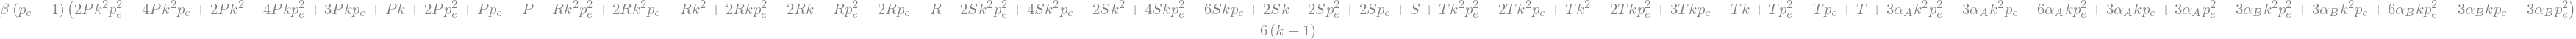

In [150]:
# incorrect
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, \
                           q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
ratio = factor(ratio.subs({p_A: x, p_B: 1 - p_e - x}))
factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1 - p_e)))

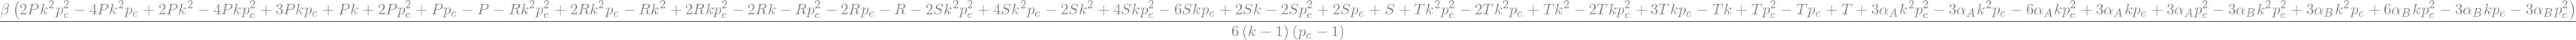

In [151]:
# correct
ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
ratio = ratio.removeO()
ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, \
                           q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
ratio = factor(ratio.subs({p_A: (1 - p_e)*x, p_B: (1 - p_e)*(1 - x)}))
factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1)))

In [152]:
# !!!!!! ?????? (1 - p_e)**2 ?????? !!!!!!
bonus = factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1)))
rho_formula = 1/N + bonus # correct
rho_formula_rescale = 1/N + factor((1 - p_e)**2*bonus) # incorrect

def fixation_thm(N_e_sub = 50, R_sub = 1, P_sub = 0, k_sub = 4, p_e_sub = 1/5, S_sub = -1, T_sub = 2, 
                 alpha_A_sub = 0, alpha_B_sub = 0, beta_sub = 0, tag = 1, rescale = False):
    '''
    rescale: True (times (1 - p_e)**2) or False
    '''
    N_sub = int(N_e_sub*(1 - p_e_sub))
    if rescale == True:
        rho = rho_formula_rescale.subs({N: N_sub, k: k_sub, p_e: p_e_sub, beta: beta_sub})
    else:
        rho = rho_formula.subs({N: N_sub, k: k_sub, p_e: p_e_sub, beta: beta_sub})
    if tag == 1:
        return rho.subs({R: R_sub, S: S_sub, T: T_sub, P: P_sub, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub})
    else:
        return rho.subs({R: P_sub, S: T_sub, T: S_sub, P: R_sub, alpha_A: alpha_B_sub, alpha_B: alpha_A_sub})

##  🥞🥞🥞 Figure 5 and 6: Theoreical calculation vs Agent-based simulation 🥞🥞🥞

In [154]:
def figure_fixation(L = 10, W = 10, k_sub = 4, u_sub_star = 0, p_e_sub = 1/5, beta_sub = 0.005, 
                    rounds = int(4*1e6), ms = 200, palette = palette_0, alpha = 0.6, 
                    fsize = (8, 6), fs = 20, graph = 'lattice', name = False):
    '''
    rescale: True (times (1 - p_e)**2) or False
    '''
    N_sub = int(L*W*(1 - p_e_sub))
    rhos_nd = [1/N_sub for _ in u_subs]
    
    fig = plt.figure(figsize = fsize)
    fig.patch.set_facecolor('white')
    ax = plt.subplot(111)
        
    plt.scatter(u_subs_sim, rhos_A_sim, s = ms, marker = 'v', c = palette[1], alpha = alpha + 0.2, zorder = 500)
    plt.scatter(u_subs_sim, rhos_B_sim, s = ms, marker = '^', c = palette[2], alpha = alpha + 0.2, zorder = 500)
    
    plt.plot(u_subs, rhos_nd, color = colors[7], linewidth = 2, linestyle = '--', label = r'$1/N$')
    if graph == 'village':
        k_sub_floor, k_sub_ceil = int(np.floor(k_sub)), int(np.ceil(k_sub))
        plt.plot(u_subs, rhos_A['wide'], color = palette[1], alpha = alpha, linewidth = 4, label = r'$\rho_A$') 
        plt.plot(u_subs, rhos_B['wide'], color = palette[2], alpha = alpha, linewidth = 4, label = r'$\rho_B$')
        plt.axvline(x = u_sub_star['floor'], ymin = 0.3, ymax = 0.7, color = colors[7], 
                    linewidth = 2, linestyle = '--')
    else:
        plt.plot(u_subs, rhos_A, color = palette[1], alpha = alpha, linewidth = 4, label = r'$\rho_A$') 
        plt.plot(u_subs, rhos_B, color = palette[2], alpha = alpha, linewidth = 4, label = r'$\rho_B$')
        plt.axvline(x = u_sub_star, ymin = 0.3, ymax = 0.7, color = colors[7], linewidth = 2, linestyle = '--')

    
    ax.set_xlabel(r'$u$', fontsize = fs - 2)
    ax.set_ylabel('fixation probability', fontsize = fs - 2)
    # ax.set_ylim(0.008, 0.014)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax.legend(loc = 'upper right', ncol = 1, fancybox = True, fontsize = fs - 4)
    notations = {1/20: r'$1/20$', 1/10: r'$1/10$', 1/5: r'$1/5$', 4/5: r'$4/5$', 9/10: r'$9/10$'}
    notations_beta = {0.005: r'$1/200$', 0.01: r'$1/100$'}
    
    if name == True:
        if beta_sub == 0.005:
            ax.set_ylim(0.005, 0.0165)
            yticks = np.arange(0.006, 0.018, 0.003)
            ax.set_yticks(yticks)
            ax.set_yticklabels([f"{tick:.3f}" for tick in yticks])
            ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 6)
            ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 6)
            ax.legend(loc = 'upper right', ncol = 1, fancybox = True, fontsize = fs - 6)
        dict_title = {'lattice': 'lattice', 'regular': 'random regular graph', 
                      'scalefree': 'scale-free network', 'village': 'real village network'}
        # plt.title(dict_title[graph] + ': ' + r'$p_e = $' + notations[p_e_sub], fontsize = fs, y = 1.01)
        plt.title(dict_title[graph], fontsize = fs, y = 1.01)
        plt.savefig(_Figure_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                    '/fig6_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.png', dpi = 600, 
                    facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    else:
        if graph == 'lattice':
            ax.set_ylim(0.0055, 0.0165)
            yticks = np.arange(0.006, 0.018, 0.002)
            ax.set_yticks(yticks)
            ax.set_yticklabels([f"{tick:.3f}" for tick in yticks])
            plt.title(r'$p_e = $' + notations[p_e_sub] + r',  $\beta = $' + notations_beta[beta_sub], fontsize = fs, y = 1.01)
        else:
            plt.title(r'$p_e = $' + notations[p_e_sub], fontsize = fs, y = 1.01)
        plt.savefig(_Figure_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                    '/fig5_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.png', dpi = 600, 
                    facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

### fixation probability data

* #### simulation
    * ##### saving
    * ##### reading
* #### theory

In [156]:
def fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(4*1e6), 
                             graph = 'lattice'):
    '''
    estimate fixation probability: saving data
    '''
    R_sub = 1
    P_sub = 0
    
    # find when rho_A = rho_B in theory
    if graph == 'village': # k is not an integer
        k_sub_floor, k_sub_ceil = int(np.floor(k_sub)), int(np.ceil(k_sub))
        print(str(k_sub_floor) + ' < ' + str(k_sub) + ' < ' + str(k_sub_ceil))
        u_sub_star_ceil = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub_floor, p_e: p_e_sub, 
                                                            S: -u, T: 1 + u}), u)[0]
        u_sub_star_ceil = np.round(np.float64(u_sub_star_ceil), 6)
        u_sub_star_floor = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub_ceil, p_e: p_e_sub, 
                                                             S: -u, T: 1 + u}), u)[0]
        u_sub_star_floor = np.round(np.float64(u_sub_star_floor), 6)
        print(str(u_sub_star_floor) + ', ' + str(u_sub_star_ceil))
        # village 10
        # u_subs_sim = np.array([0, 0.025, 0.05, 0.075, 0.1, 0.125, u_sub_star_floor, u_sub_star_ceil, 
                               # 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45]) 
        u_subs_sim = np.array([0.1, 0.125, u_sub_star_floor, u_sub_star_ceil, 0.2, 0.225, 0.25])
        # village 7
        if p_e_sub == 1/20:
            u_subs_sim = np.array([0.1, 0.125, 0.15, u_sub_star_floor, u_sub_star_ceil, 0.225, 0.25]) 
        else:
            u_subs_sim = np.array([0.1, 0.125, 0.15, u_sub_star_floor, 0.2, u_sub_star_ceil, 0.25])
    else: # k is an integer
        u_sub_star = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub, 
                                                       S: -u, T: 1 + u}), u)[0]
        u_sub_star = np.round(np.float64(u_sub_star), 6)
        print(str(u_sub_star))
        if p_e_sub == 1/20:
            u_subs_sim = np.array([0.3, 0.325, u_sub_star, 0.375, 0.4, 0.425, 0.45]) # p_e_sub = 1/20
        else:
            u_subs_sim = np.array([0.3, 0.325, 0.35, u_sub_star, 0.4, 0.425, 0.45]) # p_e_sub = 1/10
    
    rhos_A_sim = []
    stime = time.time()
    for u_sub in u_subs_sim:
        with mp.Pool(int(mp.cpu_count() - 1)) as pool:
            results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, 
                                                            -u_sub, 1 + u_sub, beta_sub, 1, graph)]*rounds))
            rhos_A_sim.append(np.sum(results == 1)/rounds)
    etime = time.time()
    print(str(round((etime - stime)/60**2, 2)) + ' hours') # 20 hours
    
    rhos_B_sim = []
    stime = time.time()
    for u_sub in u_subs_sim:
        with mp.Pool(int(mp.cpu_count() - 1)) as pool:
            results = np.array(pool.starmap(fixation_sim, [(L, W, p_e_sub, 
                                                            -u_sub, 1 + u_sub, beta_sub, 2, graph)]*rounds))
            rhos_B_sim.append(np.sum(results == 1)/rounds)
    etime = time.time()
    print(str(round((etime - stime)/60**2, 2)) + ' hours') # 20 hours
    
    # save files
    df_A = pd.DataFrame(list(zip(u_subs_sim, rhos_A_sim)), columns = ['u', 'rho'])
    df_A.to_csv(_Data_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                '/rhos_A_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')
    df_B = pd.DataFrame(list(zip(u_subs_sim, rhos_B_sim)), columns = ['u', 'rho'])
    df_B.to_csv(_Data_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                '/rhos_B_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')
    

def fixation_sim_reading_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(4*1e6), 
                              graph = 'lattice'):
    '''
    estimate fixation probability: reading data
    '''
    # agent-based simulation
    df_A = pd.read_csv(_Data_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                       '/rhos_A_' + str(int(1e3*beta_sub)) + '_' + str(int(rounds/1e5)) + '.csv', sep = '\t')
    df_B = pd.read_csv(_Data_PATH_ + graph + '/p_e=' + str(int(p_e_sub*100)) + '/N=' + str(L*W) + 
                       '/rhos_B_' + str(int(1e3*beta_sub)) + '_' + 
                       str(int(rounds/1e5)) + '.csv', sep = '\t')
    u_subs_sim = df_A['u'].to_numpy()
    rhos_A_sim = df_A['rho'].to_numpy()
    rhos_B_sim = df_B['rho'].to_numpy()
    return u_subs_sim, rhos_A_sim, rhos_B_sim

def fixation_thm_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, 
                      u_subs = np.linspace(0.2, 0.8, 301), graph = 'lattice'):
    '''
    fixation probability: theoretical calculation
    '''
    R_sub = 1
    P_sub = 0
    alpha_A_sub = alpha_B_sub = 0
    if graph == 'village': # k is not an integer
        k_sub_floor, k_sub_ceil = int(np.floor(k_sub)), int(np.ceil(k_sub))
        print(str(k_sub_floor) + ' < ' + str(k_sub) + ' < ' + str(k_sub_ceil))
        u_sub_star_ceil = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub_floor, p_e: p_e_sub, 
                                                            S: -u, T: 1 + u}), u)[0]
        u_sub_star_ceil = np.round(np.float64(u_sub_star_ceil), 6)
        u_sub_star_floor = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub_ceil, p_e: p_e_sub, 
                                                             S: -u, T: 1 + u}), u)[0]
        u_sub_star_floor = np.round(np.float64(u_sub_star_floor), 6)
        print(str(u_sub_star_floor) + ', ' + str(u_sub_star_ceil))
        stime = time.time()
        rhos_A_narrow = [fixation_thm(L*W, R_sub, P_sub, k_sub_floor, p_e_sub, 
                                      -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                                      beta_sub, 1, rescale = False) for u_sub in u_subs]
        rhos_B_narrow = [fixation_thm(L*W, R_sub, P_sub, k_sub_floor, p_e_sub, 
                                      -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                                      beta_sub, 2, rescale = False) for u_sub in u_subs]

        rhos_A_wide = [fixation_thm(L*W, R_sub, P_sub, k_sub_ceil, p_e_sub, 
                                    -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                                    beta_sub, 1, rescale = False) for u_sub in u_subs]
        rhos_B_wide = [fixation_thm(L*W, R_sub, P_sub, k_sub_ceil, p_e_sub, 
                                    -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                                    beta_sub, 2, rescale = False) for u_sub in u_subs]
        
        etime = time.time()
        print(str(round((etime - stime), 2)) + ' seconds')

        u_sub_star = {'floor': u_sub_star_floor, 'ceil': u_sub_star_ceil}
        rhos_A = {'narrow': rhos_A_narrow, 'wide': rhos_A_wide}
        rhos_B = {'narrow': rhos_B_narrow, 'wide': rhos_B_wide}
    else:
        u_sub_star = solve((flag21*p_e + flag20).subs({R: R_sub, P: P_sub, k: k_sub, p_e: p_e_sub, 
                                                       S: -u, T: 1 + u}), u)[0]
        u_sub_star = np.round(np.float64(u_sub_star), 6)
        print(str(u_sub_star))
        stime = time.time()
        rhos_A = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                               -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                               beta_sub, 1, rescale = False) for u_sub in u_subs]
        rhos_B = [fixation_thm(L*W, R_sub, P_sub, k_sub, p_e_sub, 
                               -u_sub, 1 + u_sub, alpha_A_sub, alpha_B_sub, 
                               beta_sub, 2, rescale = False) for u_sub in u_subs]
        etime = time.time()
        print(str(round((etime - stime), 2)) + ' seconds')
        
    return u_subs, u_sub_star, rhos_A, rhos_B

### 🍨🍨🍨 Example 1 🍨🍨🍨

> lattice

* donation game: $(R, S, T, P) = (1, -u, 1 + u, 0)$
* population size: $10\times5 = 50$, $10\times10 = 100$, or $20\times10 = 200$
* repetition: $4\times10^6 = 4$ million, $10\times10^6 = 10$ million, or $20\times10^6 = 20$ million
* lattice degree: $k = 4$
* emptysite fraction: $p_e = 1/20$, $p_e = 1/10$, or $p_e = 1/5 = 2/10$
* selection strength: $\beta = 0.005$

#### saving results

In [ ]:
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(4*1e6), 
                         graph = 'lattice')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.005, rounds = int(4*1e6),
                         graph = 'lattice')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.01, rounds = int(4*1e6), 
                         graph = 'lattice')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.01, rounds = int(4*1e6), 
                         graph = 'lattice')

#### reading results

0.350877
0.45 seconds


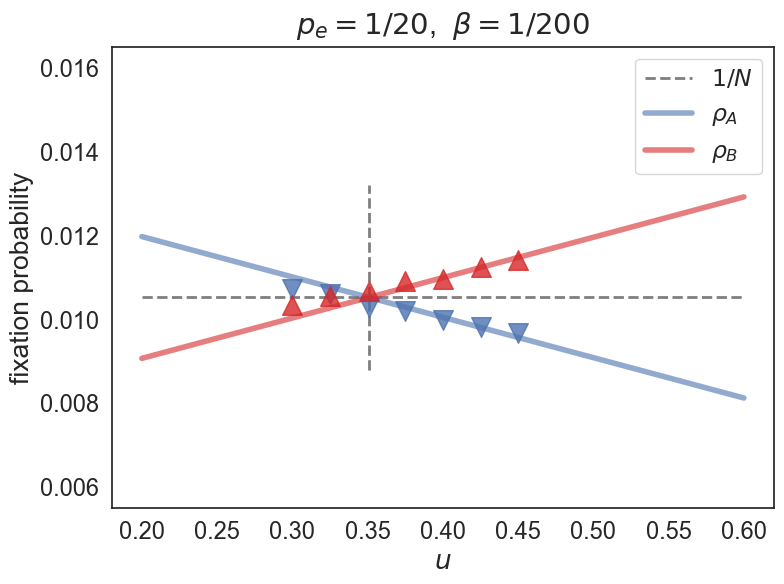

0.37037
0.37 seconds


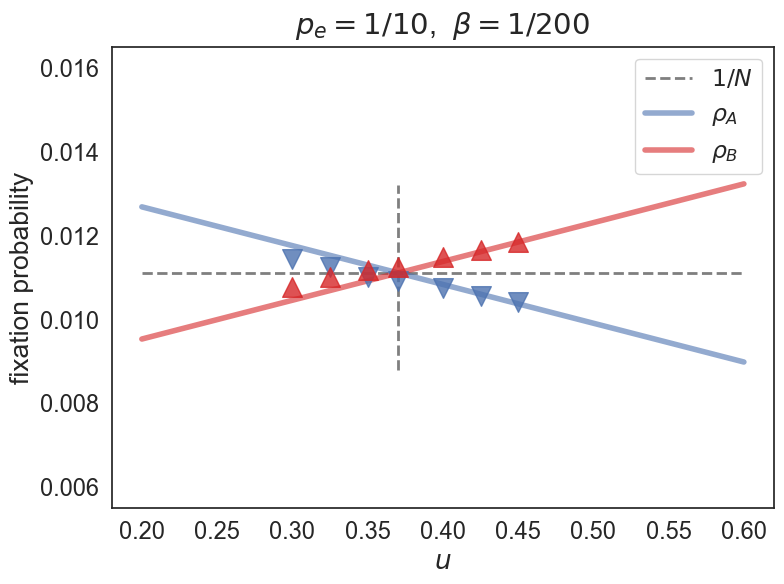

0.37037
0.34 seconds


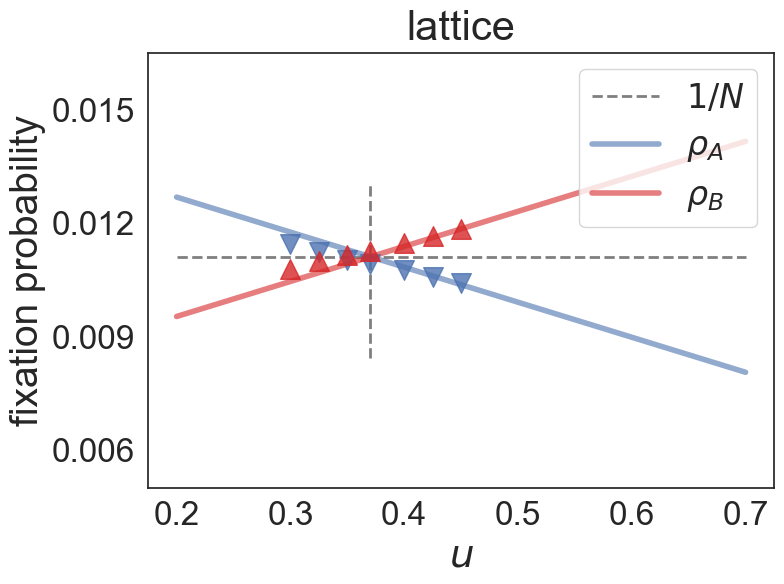

In [167]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                                   rounds = int(4*1e6), graph = 'lattice')
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                           u_subs = np.linspace(0.2, 0.6, 301), graph = 'lattice')
    figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, rounds = int(4*1e6), palette = palette_1, 
                    alpha = 0.6, fs = 21)
    if p_e_sub == 1/10:
        u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                           u_subs = np.linspace(0.2, 0.7, 301), graph = 'lattice')
        figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, rounds = int(4*1e6), palette = palette_1, 
                        alpha = 0.6, fsize = (8, 6), fs = 30, name = True)

0.350877
0.47 seconds


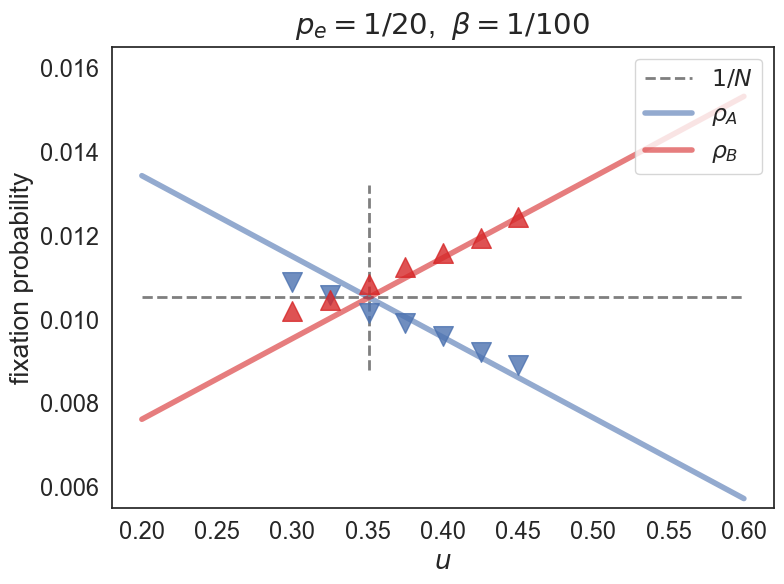

0.37037
0.34 seconds


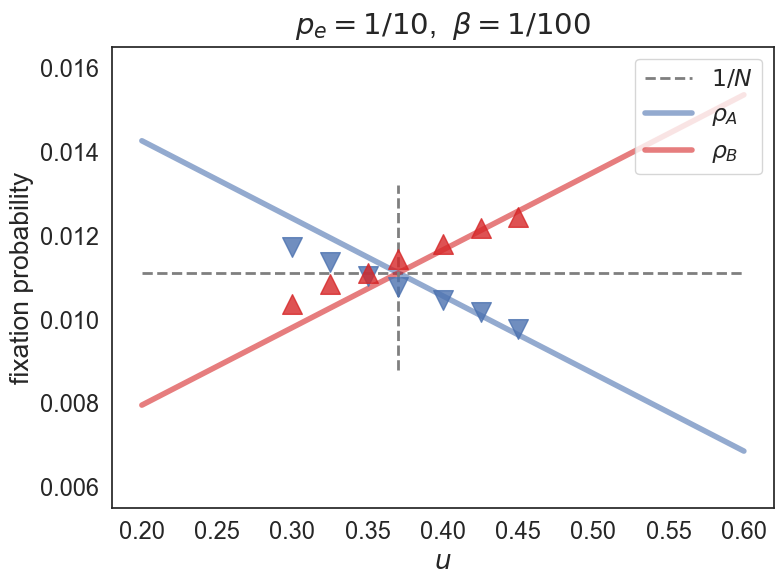

0.37037
0.33 seconds


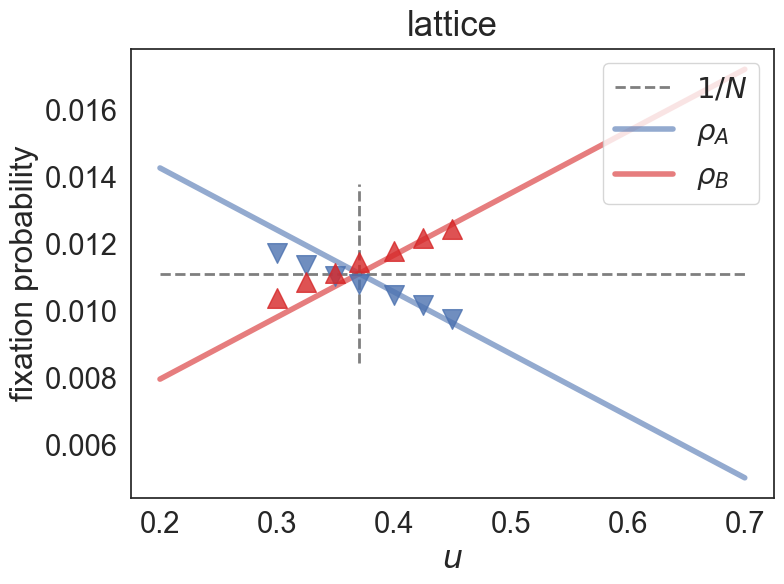

In [169]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                                   rounds = int(4*1e6), graph = 'lattice')
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                           u_subs = np.linspace(0.2, 0.6, 301), graph = 'lattice')
    figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, rounds = int(4*1e6), palette = palette_1, 
                    alpha = 0.6, fs = 21)
    if p_e_sub == 1/10:
        u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                           u_subs = np.linspace(0.2, 0.7, 301), graph = 'lattice')
        figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, rounds = int(4*1e6), palette = palette_1, 
                        alpha = 0.6, fsize = (8, 6), fs = 25, name = True)

### 🍨🍨🍨 Example 2 🍨🍨🍨

> random regular graph

* donation game: $(R, S, T, P) = (1, -u, 1 + u, 0)$
* population size: $10\times10 = 100$ or $20\times10 = 200$
* repetition: $4\times10^6 = 4$ million or $10\times10^6 = 10$ million
* lattice degree: $k = 4$
* emptysite fraction: $p_e = 1/20$ or $p_e = 1/10$
* selection strength: $\beta = 0.005$

#### saving results

In [ ]:
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(4*1e6),
                         graph = 'regular')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.005, rounds = int(4*1e6),
                         graph = 'regular')
# discrepancy between theoretical predictions and simulation results
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.01, rounds = int(4*1e6),
                         graph = 'regular')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.01, rounds = int(4*1e6),
                         graph = 'regular')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.01, rounds = int(1e7),
                         graph = 'regular')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.01, rounds = int(1e7),
                         graph = 'regular')

In [ ]:
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.008, rounds = int(4*1e6),
                         graph = 'regular')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.008, rounds = int(4*1e6),
                         graph = 'regular')

#### reading results

0.350877
0.33 seconds


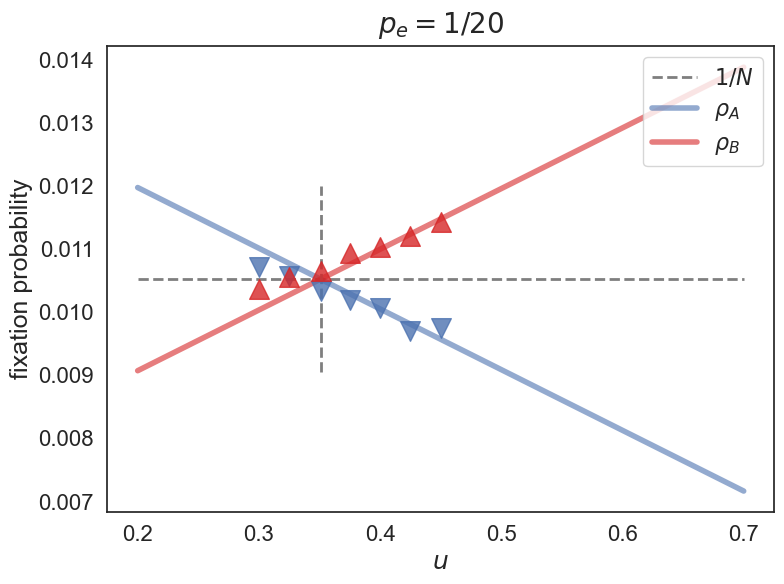

0.37037
0.35 seconds


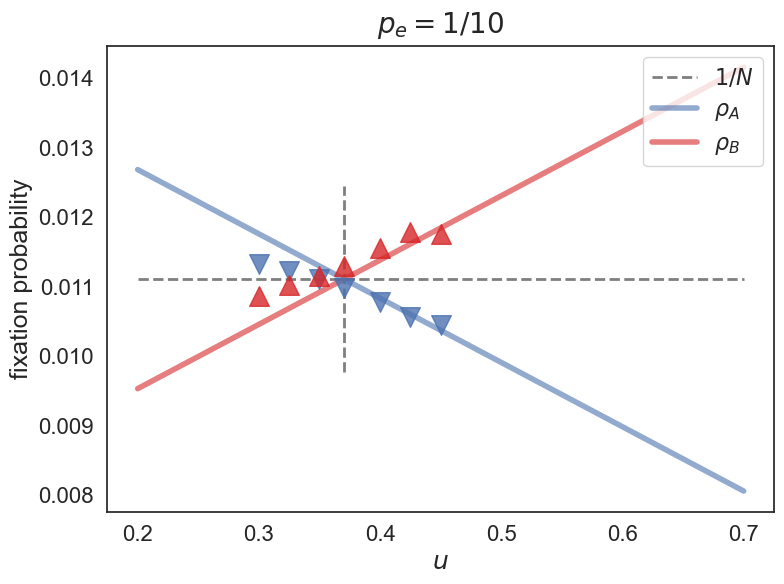

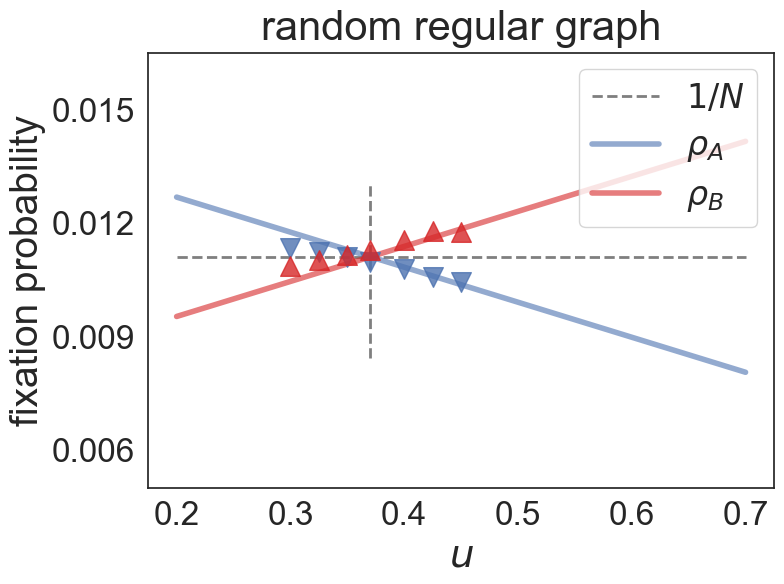

In [172]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                                   rounds = int(4*1e6), graph = 'regular')
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                           u_subs = np.linspace(0.2, 0.7, 301), graph = 'regular')
    figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                    rounds = int(4*1e6), graph = 'regular', palette = palette_1, alpha = 0.6)
    if p_e_sub == 1/10:
        figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                        rounds = int(4*1e6), graph = 'regular', palette = palette_1, alpha = 0.6, fsize = (8, 6), fs = 30, name = True)

### 🍨🍨🍨 Example 3 🍨🍨🍨

> scale free

* donation game: $(R, S, T, P) = (1, -u, 1 + u, 0)$
* population size: $10\times10 = 100$ or $20\times10 = 200$
* repetition: $4\times10^6 = 4$ million or $10\times10^6 = 10$ million
* lattice degree: $k = 4$
* emptysite fraction: $p_e = 1/20$ or $p_e = 1/10$
* selection strength: $\beta = 0.005$

#### saving results

In [ ]:
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(1e7), 
                         graph = 'scalefree')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.005, rounds = int(1e7), 
                         graph = 'scalefree')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/20, beta_sub = 0.01, rounds = int(1e7), 
                         graph = 'scalefree')
fixation_sim_saving_data(L = 10, W = 10, k_sub = 4, p_e_sub = 1/10, beta_sub = 0.01, rounds = int(1e7), 
                         graph = 'scalefree')

#### reading results

0.350877
0.36 seconds


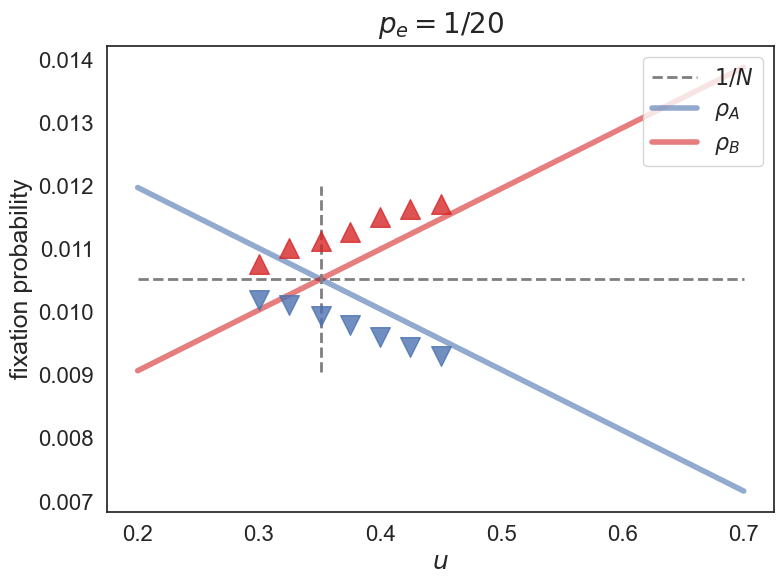

0.37037
0.34 seconds


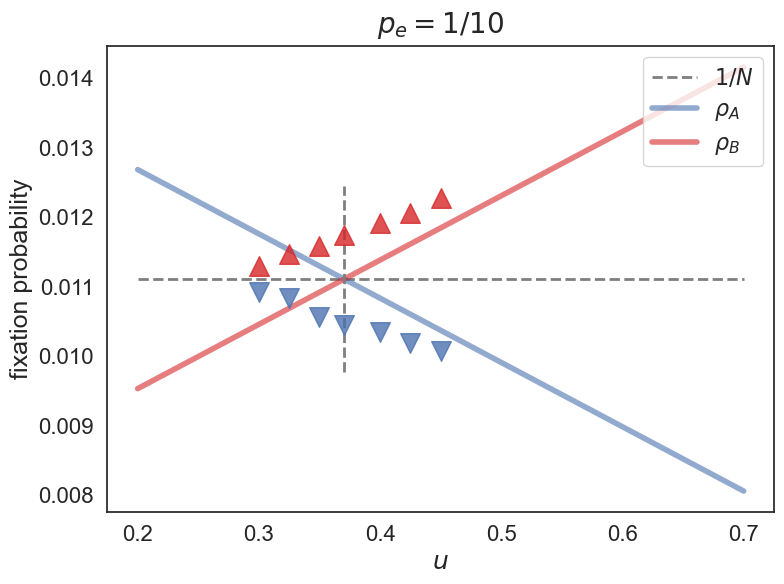

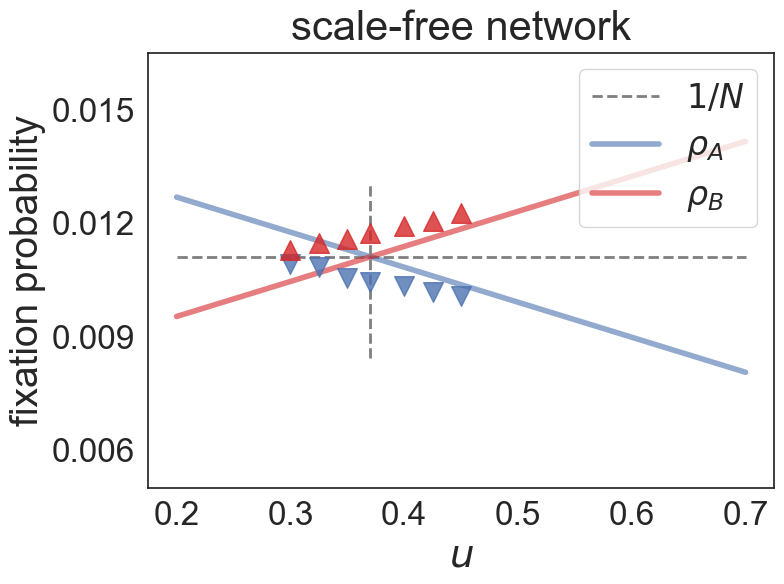

In [174]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                                   rounds = int(1e7), graph = 'scalefree')
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                           u_subs = np.linspace(0.2, 0.7, 301), 
                                                           graph = 'scalefree')
    figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                    rounds = int(1e7), graph = 'scalefree', palette = palette_1, alpha = 0.6)
    if p_e_sub == 1/10:
        figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                        rounds = int(1e7), graph = 'scalefree', palette = palette_1, alpha = 0.6, fsize = (8, 6), fs = 30, name = True)

0.350877
0.35 seconds


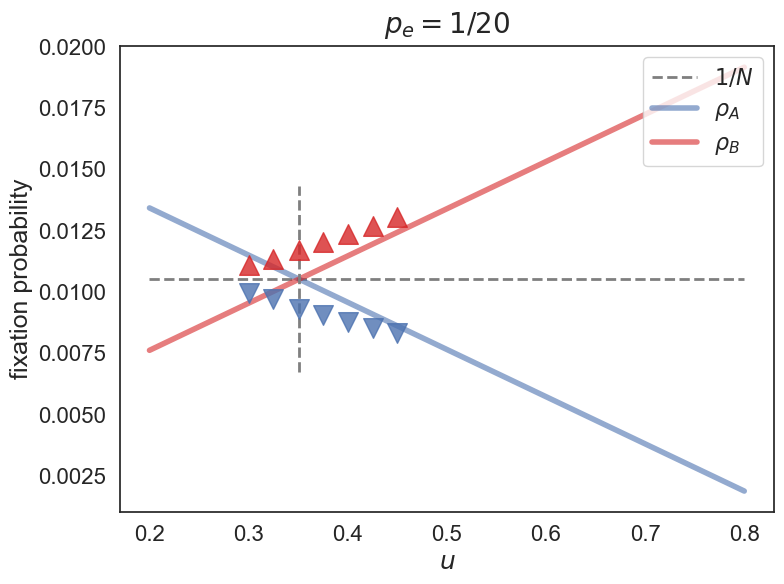

0.37037
0.44 seconds


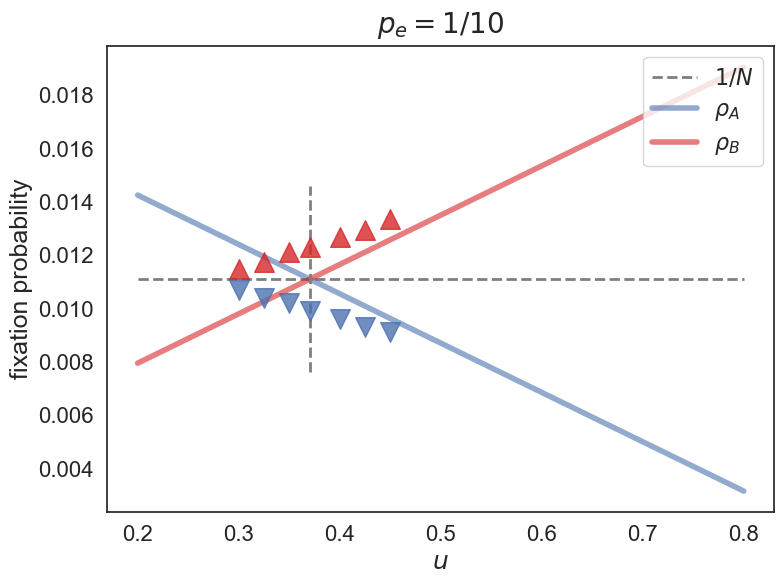

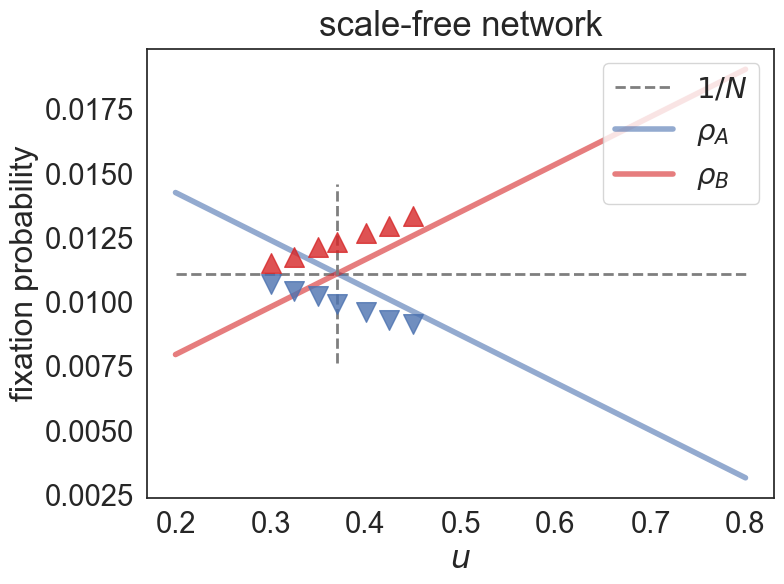

In [176]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                                   rounds = int(1e7), graph = 'scalefree')
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                           u_subs = np.linspace(0.2, 0.8, 301), 
                                                           graph = 'scalefree')
    figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, 
                    rounds = int(1e7), graph = 'scalefree', palette = palette_1, alpha = 0.6)
    if p_e_sub == 1/10:
        figure_fixation(u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, 
                        rounds = int(1e7), graph = 'scalefree', palette = palette_1, alpha = 0.6, fsize = (8, 6), fs = 25, name = True)

### 🍨🍨🍨 Example 4 🍨🍨🍨

> village

* donation game: $(R, S, T, P) = (1, -u, 1 + u, 0)$
* population size: $10\times10 = 100$ or $20\times10 = 200$
* repetition: $40\times10^5 = 4$ million or $100\times10^5 = 10$ million
* lattice degree: $k \approx 8$
* emptysite fraction: $p_e = 1/20$ or $p_e = 1/10$
* selection strength: $\beta = 0.005$

#### saving results

In [ ]:
# the actual degree is not an integer
L = 10
W = 10
k_sub = 2*dict_G[L*W].number_of_edges()/dict_G[L*W].number_of_nodes()
fixation_sim_saving_data(L = L, W = W, k_sub = k_sub, p_e_sub = 1/20, beta_sub = 0.005, rounds = int(4*1e6), 
                         graph = 'village')
fixation_sim_saving_data(L = L, W = W, k_sub = k_sub, p_e_sub = 1/10, beta_sub = 0.005, rounds = int(4*1e6), 
                         graph = 'village')
fixation_sim_saving_data(L = L, W = W, k_sub = k_sub, p_e_sub = 1/20, beta_sub = 0.01, rounds = int(4*1e6), 
                         graph = 'village')
fixation_sim_saving_data(L = L, W = W, k_sub = k_sub, p_e_sub = 1/10, beta_sub = 0.01, rounds = int(4*1e6), 
                         graph = 'village')

#### reading results

6 < 6.16 < 7
0.175439, 0.210526
0.7 seconds


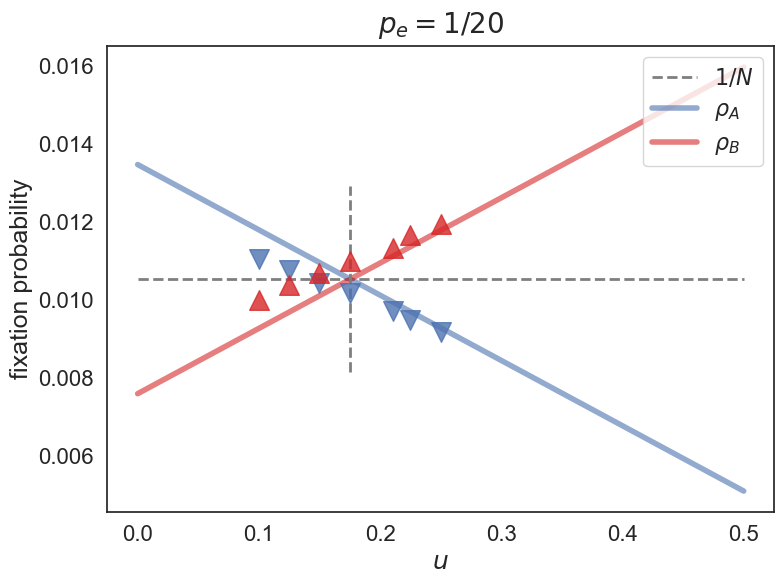

6 < 6.16 < 7
0.185185, 0.222222
0.76 seconds


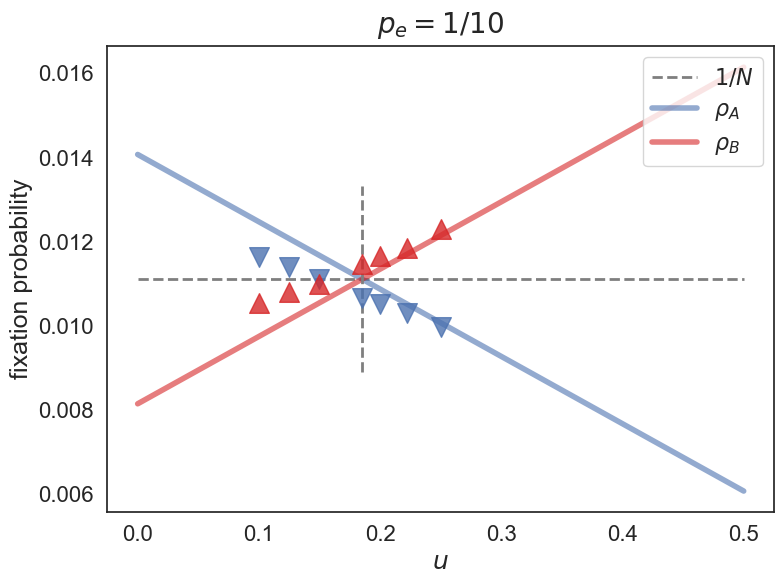

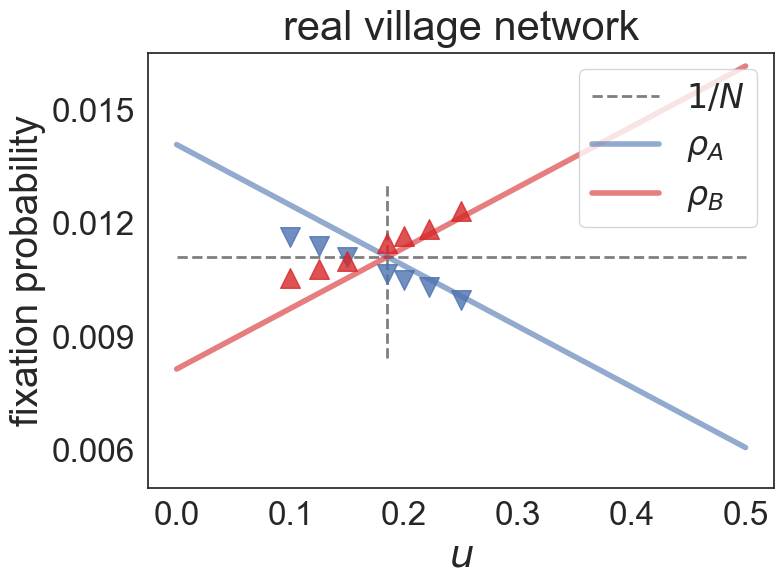

In [180]:
L = 10
W = 10
k_sub = 2*dict_G[L*W].number_of_edges()/dict_G[L*W].number_of_nodes()
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(L = L, W = W, k_sub = k_sub, 
                                                                   p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                                   rounds = int(4*1e6), 
                                                                   graph = 'village')
    indices = np.where((u_subs_sim >= 0.1) & (u_subs_sim <= 0.25))
    u_subs_sim = u_subs_sim[indices]
    rhos_A_sim = rhos_A_sim[indices]
    rhos_B_sim = rhos_B_sim[indices]
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(L = L, W = W, k_sub = k_sub, 
                                                           p_e_sub = p_e_sub, beta_sub = 0.005, 
                                                           u_subs = np.linspace(0, 0.5, 301), 
                                                           graph = 'village')
    figure_fixation(k_sub = k_sub, u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                    rounds = int(4*1e6), graph = 'village', palette = palette_1, alpha = 0.6)
    
    if p_e_sub == 1/10:
        figure_fixation(k_sub = k_sub, u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.005, 
                        rounds = int(4*1e6), graph = 'village', palette = palette_1, alpha = 0.6, fsize = (8, 6), fs = 30, name = True)

6 < 6.16 < 7
0.175439, 0.210526
0.69 seconds


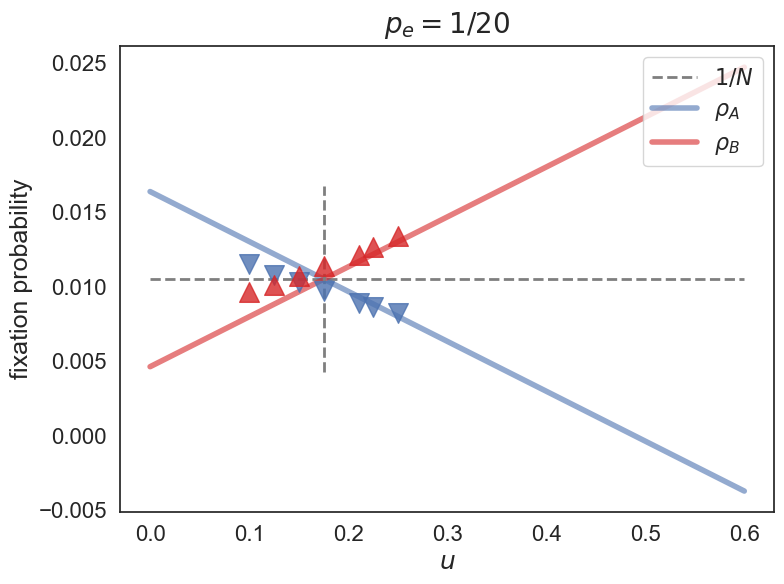

6 < 6.16 < 7
0.185185, 0.222222
0.68 seconds


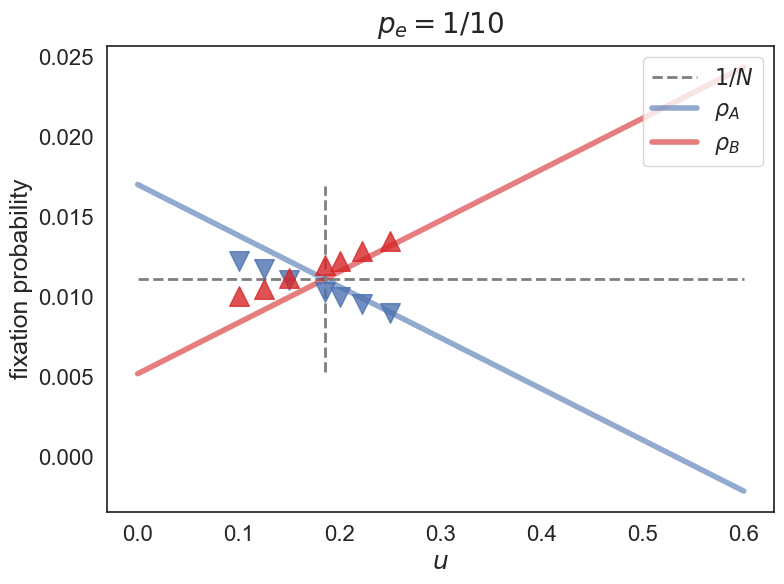

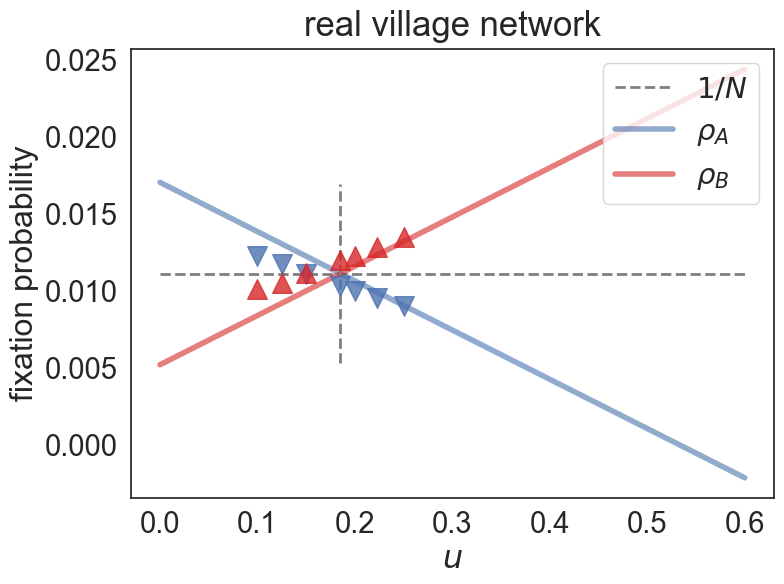

In [182]:
for p_e_sub in [1/20, 1/10]:
    u_subs_sim, rhos_A_sim, rhos_B_sim = fixation_sim_reading_data(L = L, W = W, k_sub = k_sub, 
                                                                   p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                                   rounds = int(4*1e6), 
                                                                   graph = 'village')
    indices = np.where((u_subs_sim >= 0.1) & (u_subs_sim <= 0.25))
    u_subs_sim = u_subs_sim[indices]
    rhos_A_sim = rhos_A_sim[indices]
    rhos_B_sim = rhos_B_sim[indices]
    u_subs, u_sub_star, rhos_A, rhos_B = fixation_thm_data(L = L, W = W, k_sub = k_sub, 
                                                           p_e_sub = p_e_sub, beta_sub = 0.01, 
                                                           u_subs = np.linspace(0, 0.6, 301), 
                                                           graph = 'village')
    figure_fixation(k_sub = k_sub, u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, 
                    rounds = int(4*1e6), graph = 'village', palette = palette_1, alpha = 0.6)
    
    if p_e_sub == 1/10:
        figure_fixation(k_sub = k_sub, u_sub_star = u_sub_star, p_e_sub = p_e_sub, beta_sub = 0.01, 
                        rounds = int(4*1e6), graph = 'village', palette = palette_1, alpha = 0.6, fsize = (8, 6), fs = 25, name = True)

## 🍨🍨🍨 Revision A 🍨🍨🍨

> empty sites as a third type

#### payoff matrix

\begin{equation}
M = \begin{pmatrix} R & S & \alpha_A \\ T & P & \alpha_B \\ 0 & 0 & 0 \end{pmatrix}
\end{equation}

In [184]:
# substitutions
def fixation_probability_nc():
    '''
    where there are two strategies in the population of size N_e
    '''
    a, b, c, d = symbols('a, b, c, d', real = True) # payoff structure
    q_AA_sub = p_A + (1 - p_A)/(k - 1)
    q_BB_sub = p_B + (1 - p_B)/(k - 1)
    q_BA_sub = p_B - p_B/(k - 1)
    q_AB_sub = p_A - p_A/(k - 1)
    pi_AA_sub = a + (k - 1)*(q_AA*a + q_BA*b) 
    pi_BA_sub = c + (k - 1)*(q_AB*c + q_BB*d)
    pi_AB_sub = b + (k - 1)*(q_AA*a + q_BA*b)
    pi_BB_sub = d + (k - 1)*(q_AB*c + q_BB*d)
    
    n_AA, n_BA, n_AB, n_BB = k*q_AA, k*q_BA, k*q_AB, k*q_BB # number of neighbors
    f_AA, f_BA, f_AB, f_BB = exp(beta*pi_AA), exp(beta*pi_BA), exp(beta*pi_AB), exp(beta*pi_BB) # fitness
    T_A_backward = p_A*n_BA*f_BA/(n_AA*f_AA + n_BA*f_BA)
    T_A_forward = p_B*n_AB*f_AB/(n_AB*f_AB + n_BB*f_BB)
    ratio = factor(T_A_backward/T_A_forward).series(beta, x0 = 0, n = 2) # Taylor expansion
    ratio = ratio.removeO()
    ratio = factor(ratio.subs({pi_AA: pi_AA_sub, pi_BA: pi_BA_sub, pi_AB: pi_AB_sub, pi_BB: pi_BB_sub, \
                               q_AA: q_AA_sub, q_BA: q_BA_sub, q_AB: q_AB_sub, q_BB: q_BB_sub}))
    ratio = factor(ratio.subs({p_A: x, p_B: 1 - x}))
    bonus = factor(integrate(integrate((1 - ratio).subs({x: y}), (y, 0, x)), (x, 0, 1)))
    rho_formula = 1/N_e + bonus
    return rho_formula

def abundance_sym():
    '''
    symbolic abundance
    under the rare mutation limit
    with the payoff structure [R, S, alpha_A; T, P, alpha_B; 0, 0, 0]
    rho_ij: the fixation probability that a single mutant of strategy j invades and takes over the entire population of strategy i
    '''
    a, b, c, d = symbols('a, b, c, d', real = True) # payoff structure
    rho_formula = fixation_probability_nc()
    M = np.array([[R, S, alpha_A],[T, P, alpha_B], [0, 0, 0]])
    RHO = [[None for _ in range(3)] for _ in range(3)]
    for i in range(3):
        for j in range(3):
            RHO[i][j] = rho_formula.subs({a: M[j][j], b: M[j][i], c: M[i][j], d: M[i][i]})
    # null case
    abundances_null = [RHO[1][0]/(RHO[1][0] + RHO[0][1]), RHO[0][1]/(RHO[1][0] + RHO[0][1])]
    # case with empty sites
    gamma_1 = RHO[1][0]*RHO[2][0] + RHO[1][0]*RHO[2][1] + RHO[2][0]*RHO[1][2]
    gamma_2 = RHO[2][0]*RHO[0][1] + RHO[0][1]*RHO[2][1] + RHO[2][1]*RHO[0][2]
    gamma_3 = RHO[1][0]*RHO[0][2] + RHO[0][1]*RHO[1][2] + RHO[0][2]*RHO[1][2]
    gamma = gamma_1 + gamma_2 + gamma_3
    abundances_es = [gamma_1/gamma, gamma_2/gamma, gamma_3/gamma]
    return abundances_null, abundances_es

def abundance_num(dict_param):
    '''
    numerical abundance
    '''
    abundances_null, abundances_es = abundance_sym()
    abundances_null = [factor(abu.subs(dict_param)) for abu in abundances_null]
    abundances_es = [factor(abu.subs(dict_param)) for abu in abundances_es]
    return abundances_null, abundances_es

> Taylor expansion of order one with respect to $\beta$

In [187]:
abundances_null, abundances_es = abundance_sym()
xc_es, xd_es, xes_es = [factor(factor(abundances_es[j]).series(beta, x0 = 0, n = 2).removeO()) for j in range(3)]
# the abundance of C - 1/3
term1 = factor((xc_es - 1/3)*(18*(k - 1))/(N_e*k*beta))
# the abundance of C - the abundance of D
term2 = factor((xc_es - xd_es)*(18*(k - 1))/(N_e*k*beta))

### Abundances: Equation (S36)

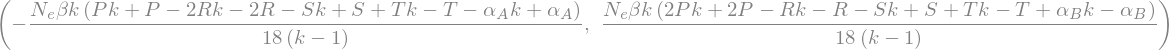

In [189]:
factor(xc_es - 1/3), factor(xd_es - 1/3)

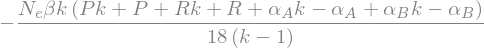

In [192]:
# the abundance of ES - 1/3
factor(xes_es - 1/3)

#### $\rho_A > \rho_B$ versus $\lambda_A > \lambda_B$: Equations (S37 - S39) and Equations (33 - 34)

> 🍧 comparision between static and dynamic empty sites 🍧

In [195]:
# static empty sites
# deleting the term with respect to N_e*beta
flag_static_taylor = (k + 2)*(R - P) - (k - 1)*(T - S) + (k - 1)*(alpha_A - alpha_B)
flag_static = factor((flag2.coeff(p_e, 1)*1/3 + flag2.coeff(p_e, 0))*3/2)
flag_static = collect(collect(collect(collect(collect(collect(flag_static, R), S), T), P), alpha_A), alpha_B)
# without deleting the term with respect to N_e*beta
flag_static = flag_static + factor(flag2.coeff(p_e, 1)*(xes_es - 1/3)*3/2)
# dynamic empty sites
flag_dynamic = 3*(k + 1)*(R - P) - 2*(k - 1)*(T - S) + (k - 1)*(alpha_A - alpha_B)
flag_static_taylor, flag_dynamic

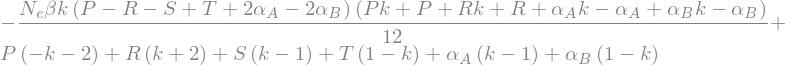

In [197]:
flag_static

In [199]:
def figure_comparison(N_e_sub = 100, R_sub = 1, P_sub = 0, k_sub = 4, alpha_A_sub = 0, alpha_B_sub = 0, beta_sub = 0.001,
                      lw = 2, ms = 10, fsize = (8, 6), fs = 20):
    '''
    comparision between static and dynamic empty sites
    '''
    S_min, T_max = -2, 3 # -1, 2
    S_subs = np.linspace(S_min, R_sub, 501)

    dict_param = {N_e: N_e_sub, R: R_sub, P: P_sub, k: k_sub, alpha_A: alpha_A_sub, alpha_B: alpha_B_sub, beta: beta_sub}

    line_static_taylor = lambdify([S], solve(flag_static_taylor.subs(dict_param), T)[0])
    line_static = lambdify([S], solve(flag_static.subs(dict_param), T)[0])
    line_dynamic = lambdify([S], solve(flag_dynamic.subs(dict_param), T)[0])
    notations = {0: r'$0$', 1: r'$1$', 2: r'$2$'}
    a = [0.2, 0.4, 0.6, 0.8]
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios': [3, 1]}, figsize = fsize)
    sns.set_style('white')
    fig.patch.set_facecolor('white')

    # ax0.plot(S_subs, line_static_taylor(S_subs), color = 'black', linewidth = lw, linestyle = '--', alpha = a[3], zorder = 500)
    ax0.plot(S_subs, line_static(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.plot(S_subs, line_dynamic(S_subs), color = 'black', linewidth = lw, alpha = a[3], zorder = 500)
    ax0.fill_between(S_subs, np.min([line_static(S_subs), line_dynamic(S_subs)], axis = 0), color = colors[0], alpha = a[1])
    ax0.fill_between(S_subs, np.max([line_static(S_subs), line_dynamic(S_subs)], axis = 0), T_max, 
                     color = colors[3], alpha = a[1])

    ax0.fill_between(S_subs, np.min([line_static(S_subs), line_dynamic(S_subs)], axis = 0), 
                     np.max([line_static(S_subs), line_dynamic(S_subs)], axis = 0),
                     color = colors[2] if line_static(S_min) < line_dynamic(S_min) else colors[6], alpha = a[1])
    
    
    # prisoner's dilemma
    points = [[S_min, R_sub], [P_sub, R_sub], [P_sub, T_max], [S_min, T_max]]
    square_PD = plt.Polygon(points, facecolor = 'none', hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[0])
    # snowdrift game
    points = [[P_sub, R_sub], [R_sub, R_sub], [R_sub, T_max], [P_sub, T_max]]
    square_SD = plt.Polygon(points, facecolor = 'none', hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[0])
    # stag-hunt game
    points = [[S_min, P_sub], [P_sub, P_sub], [P_sub, R_sub], [S_min, R_sub]]
    square_SH = plt.Polygon(points, facecolor = 'none', hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[0])
    # donation game
    line = plt.Line2D((S_min, P_sub), (T_max, R_sub), c = 'black', lw = lw, ls = '--', marker = '.', markersize = 0, alpha = a[3], 
                      zorder = 500)
    ax0.add_patch(square_PD)
    ax0.add_patch(square_SD)
    ax0.add_patch(square_SH)
    ax0.add_line(line)
    # boundaries
    line = plt.Line2D((S_min, R_sub), (R_sub, R_sub), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[2])
    ax0.add_line(line)
    line = plt.Line2D((P_sub, P_sub), (P_sub, T_max), c = 'white', lw = 2*lw, marker = '.', markersize = 0, alpha = a[2])
    ax0.add_line(line)
    
    # notations and arrows
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8', color = 'black')

    if alpha_A_sub - alpha_B_sub == 0:
        ax0.text(-1, 0.4, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_static = mpatches.FancyArrowPatch((-1.2, line_static(-1.2)), (-0.8, 0.55), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        ax0.text(-0.85, 2.6, r'$\lambda_A = \lambda_B$', fontsize = fs - 2)
        arrow_dynamic = mpatches.FancyArrowPatch((-0.2, line_dynamic(-0.2)), (-0.6, 2.5), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        
    elif alpha_A_sub - alpha_B_sub > 0:
        ax0.text(-1, 1.1, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_static = mpatches.FancyArrowPatch((-1.2, line_static(-1.2)), (-0.8, 1.25), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        ax0.text(-1.2, 2.7, r'$\lambda_A = \lambda_B$', fontsize = fs - 2)
        arrow_dynamic = mpatches.FancyArrowPatch((-0.5, line_dynamic(-0.5)), (-0.9, 2.6), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
    else:
        ax0.text(-0.8, 0.2, r'$\rho_A = \rho_B$', fontsize = fs - 2)
        arrow_static = mpatches.FancyArrowPatch((-0.5, line_static(-0.5)), (-0.3, 0.35), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
        ax0.text(-0.8, 2.2, r'$\lambda_A = \lambda_B$', fontsize = fs - 2)
        arrow_dynamic = mpatches.FancyArrowPatch((-0.2, line_dynamic(-0.2)), (-0.3, 2.1), 
                                           connectionstyle = "arc3, rad = -0.25", **kw, zorder = 500)
    ax0.add_patch(arrow_static)
    ax0.add_patch(arrow_dynamic)
    
    ax0.set_title(r'$\alpha_A = $' + notations[alpha_A_sub] + r',  $\alpha_B = $' + notations[alpha_B_sub], fontsize = fs, y = 1.01)            
    ax0.set_xlabel(r'$S$', fontsize = fs - 2)
    ax0.set_ylabel(r'$T$', fontsize = fs - 2)
    ax0.set_xlim([S_min, R_sub])
    ax0.set_ylim([P_sub, T_max])
    ax0.set_xticks(np.arange(S_min, R_sub + 0.5, (lambda x: 0.5 if x < 3 else 1)(T_max)))
    ax0.set_yticks(np.arange(P_sub, T_max + 0.5, (lambda x: 0.5 if x < 3 else 1)(T_max)))
    ax0.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax0.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    ax0.set_aspect('equal')
    
    # sub figure: legend
    ax1.axis('off')
    patch_pd = mpatches.Patch(facecolor = colors[0], hatch = '+', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "PD (upper left quadrant)")
    patch_sd = mpatches.Patch(facecolor = colors[0], hatch = '|', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "SD (upper right quadrant)")
    patch_sh = mpatches.Patch(facecolor = colors[0], hatch = '-', edgecolor = 'white', linewidth = 0, alpha = a[2], 
                              label = "SH (lower left quadrant)")
    patch0 = mpatches.Patch(color = colors[0], alpha = a[2], linewidth = 0, label = r'$\rho_A > \rho_B$' + r',  $\lambda_A > \lambda_B$')
    patch1 = mpatches.Patch(color = colors[2], alpha = a[2], linewidth = 0, label = r'$\rho_A < \rho_B$' + r',  $\lambda_A > \lambda_B$')
    patch2 = mpatches.Patch(color = colors[3], alpha = a[2], linewidth = 0, label = r'$\rho_A < \rho_B$' + r',  $\lambda_A < \lambda_B$')
    ax1.legend(handles = [patch_pd, patch_sd, patch_sh, patch0, patch1, patch2], handleheight = 2, handlelength = 1.6, 
               loc = 'center', ncol = 1, bbox_to_anchor = (0.5, 0.5), fancybox = True, fontsize = fs - 6)

    plt.savefig(_Figure_PATH_ + 'Rfig1_' + str(int(alpha_A_sub)) + '_' + str(int(alpha_B_sub)) + '.png', dpi = 600, 
                facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
    plt.show()

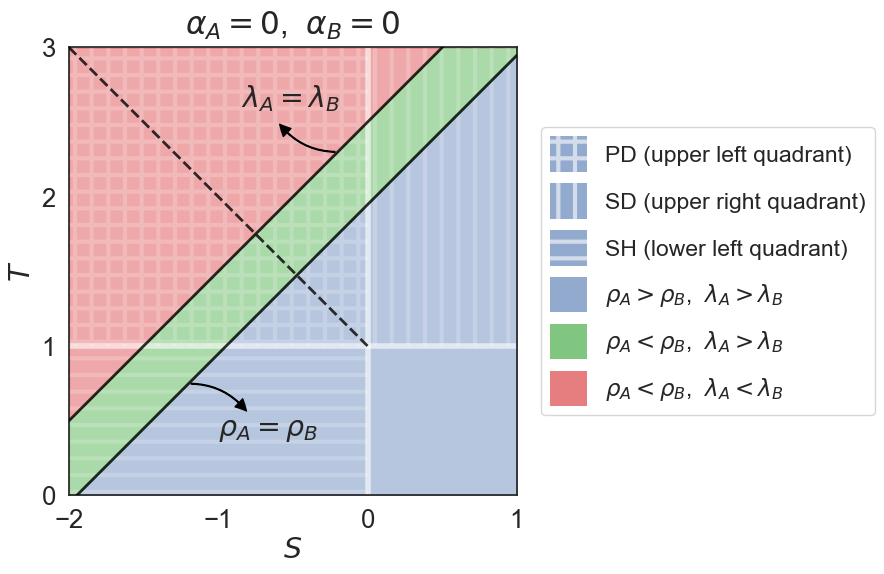

In [201]:
figure_comparison(alpha_A_sub = 0, alpha_B_sub = 0, fsize = (9, 6), fs = 22.5)

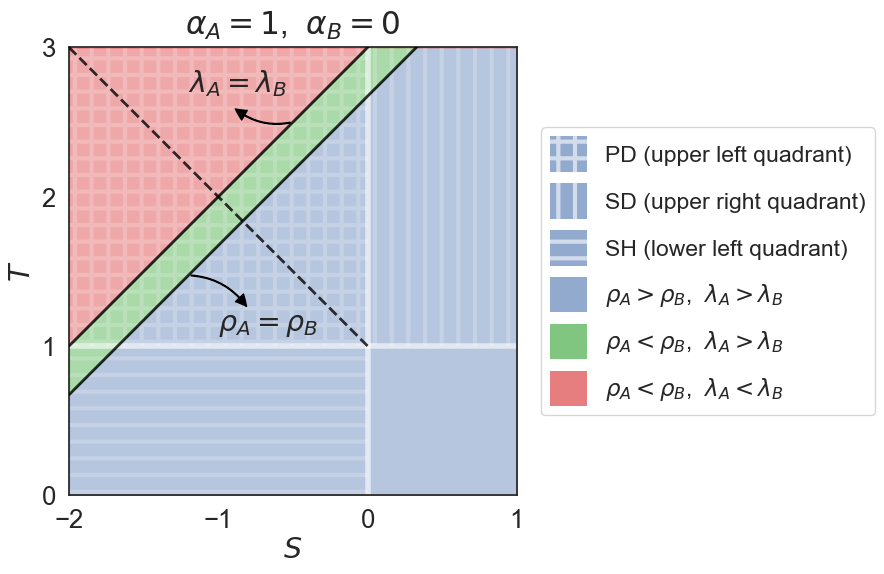

In [203]:
figure_comparison(alpha_A_sub = 1, alpha_B_sub = 0, fsize = (9, 6), fs = 22.5)

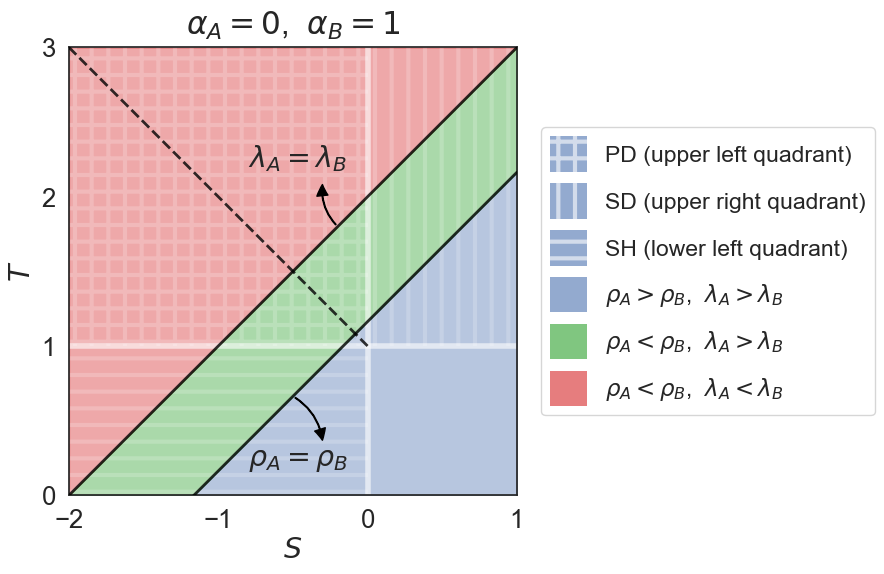

In [205]:
figure_comparison(alpha_A_sub = 0, alpha_B_sub = 1, fsize = (9, 6), fs = 22.5)

### 🍨🍨🍨 Revision B 🍨🍨🍨

> empty sites as a reactive strategy

#### payoff matrix

\begin{equation}
M = \begin{pmatrix} R & S & \alpha_A \\ T & P & \alpha_B \\ 0 & 0 & 0 \end{pmatrix}
\end{equation}

#### reactive strategy: $[q_1, q_2, q_1, q_2]$

In [208]:
# strategies
p_1, p_2, p_3, p_4 = symbols('p_1, p_2, p_3, p_4', nonnegative = True) # my probabilities to cooperate
q_1, q_2, q_3, q_4 = symbols('q_1, q_2, q_3, q_4', nonnegative = True) # my opponent's probabilities to cooperate
def interaction(payments = False, job = 'reactive'):
    '''
    payments: payff structure [R, S, T, P]
    job: 'reactive' or 'memory-one'
    '''
    # ALLC
    Cooperator_p = [(p_1, 1), (p_2, 1), (p_3, 1), (p_4, 1)]
    Cooperator_q = [(q_1, 1), (q_2, 1), (q_3, 1), (q_4, 1)]
    # ALLD
    Defector_p = [(p_1, 0), (p_2, 0), (p_3, 0), (p_4, 0)]
    Defector_q = [(q_1, 0), (q_2, 0), (q_3, 0), (q_4, 0)]
    
    A_1 = Matrix([[-1 + p_1*q_1, -1 + p_1, -1 + q_1, 1], # matrix for the determinant D(p, q, 1)
                  [p_2*q_3, -1 + p_2, q_3, 1],
                  [p_3*q_2, p_3, -1 + q_2, 1],
                  [p_4*q_4, p_4, q_4, 1]])
    A_X = Matrix([[-1 + p_1*q_1, -1 + p_1, -1 + q_1, R], # matrix for the determinant D(p, q, S_X)
                  [p_2*q_3, -1 + p_2, q_3, S],
                  [p_3*q_2, p_3, -1 + q_2, T],
                  [p_4*q_4, p_4, q_4, P]])
    s_X = A_X.det()/A_1.det() # my payoff
    if job == 'reactive':
        alpha_A_re = factor(s_X.subs(Cooperator_p + [(q_3, q_1), (q_4, q_2)]))
        alpha_B_re = factor(s_X.subs(Defector_p + [(q_3, q_1), (q_4, q_2)]))
        return alpha_A_re, alpha_B_re
    else:
        alpha_A_m1 = factor(s_X.subs(Cooperator_p))
        alpha_B_m1 = factor(s_X.subs(Defector_p))
        return alpha_A_m1, alpha_B_m1

In [210]:
factor(-fraction(rho_formula - 1/N)[0]/beta - flag1), -fraction(rho_formula - 1/N)[1]

#### $\alpha_A$, $\alpha_B$, and $\alpha_A - \alpha_B$
#### Equations (S40 - S41) and Equation (35)

In [213]:
alpha_A_re, alpha_B_re = interaction(job = 'reactive')
flag_raw = collect(collect(factor(alpha_A_re - alpha_B_re), q_1), q_2)
flag_re = (R - S)*q_1 - (T - P)*q_2 - (P - S)
alpha_A_re, alpha_B_re, flag_re

#### Equation (S42) and Equation (36)

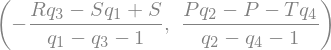

In [216]:
alpha_A_m1, alpha_B_m1 = interaction(job = 'memory-one')
alpha_A_m1, alpha_B_m1

In [218]:
def figure_reactive_ES(N_e_sub = 100, p_e_sub = 1/5, R_sub = 1, P_sub = 0, u_subs = [0, 1, 2], k_sub = 4, beta_sub = 0.001,  
                       lw = 2, ms = 10, fsize = (6, 6), fs = 20):
    
    alpha_A_sub, alpha_B_sub = interaction(job = 'reactive')
    temp = rho_formula.subs({alpha_A: alpha_A_sub, alpha_B: alpha_B_sub})
    temp = temp.subs({N: N_e_sub*(1 - p_e_sub), p_e: p_e_sub, R: R_sub, P: P_sub, k: k_sub, beta: beta_sub})

    q_1_subs = np.linspace(0, 1, 501)
    q_2_subs = np.linspace(0, 1, 501)
    X, Y = np.meshgrid(q_1_subs, q_2_subs)

   # compute all Z values and find global min/max
    Z_list = []
    for u_sub in u_subs:
        expr = temp.subs({S: -u_sub, T: 1 + u_sub})
        rho = lambdify([q_1, q_2], expr)
        Z = rho(X, Y)
        Z_list.append(Z)

    
    fig = plt.figure(figsize = fsize)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111, projection = '3d')
    # notations and arrows
    kw = dict(arrowstyle = 'Simple, tail_width = 0.5, head_width = 8, head_length = 8')
    
    for j, u_sub in enumerate(u_subs):
        Z = Z_list[j]
        Z_norm = (Z - Z.min())/(Z.max() - Z.min())
        surf = ax.plot_surface(X, Y, u_sub * np.ones_like(Z), facecolors = plt.cm.summer(Z_norm), alpha = 0.8, 
                               linewidth = 0, rstride = 2, cstride = 2)
    
        # find max location
        max_idx = np.unravel_index(np.argmax(Z), Z.shape)
        x_max = X[max_idx]
        y_max = Y[max_idx]
        z_max = u_sub  # all points lie on the same z level per u_sub
        ax.quiver(x_max, y_max, z_max + 0.25, # <-- starting point of vector
        0, 0, -0.25, # <-- directions of vector
        color = plt.cm.summer(0.99), alpha = 0.8, lw = 2, length = 0.95)

    # add a colorbar separately based on the real Z values
    mappable = plt.cm.ScalarMappable(cmap = plt.cm.summer, norm = mcolors.Normalize(vmin = Z.min(), vmax = Z.max()))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, shrink = 0.5, aspect = 15, ax = ax, pad = 0.075)
    cbar.set_ticks([Z.min(), Z.max()])
    cbar.set_ticklabels(['min', 'max'])
    ax.set_xlim3d(0, 1)
    ax.set_xlabel(r'$q_1$', fontsize = fs - 2)
    ax.set_ylim3d(0, 1)
    ax.set_ylabel(r'$q_2$', fontsize = fs - 2)
    ax.set_zlim3d(0, np.max(u_subs))
    ax.set_zticks(u_subs)
    ax.set_zlabel(r'$u$', fontsize = fs - 2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.1)
    ax.spines['left'].set_linewidth(0.1)

    plt.tight_layout()

    plt.savefig(_Figure_PATH_ + 'Rfig2' + '.png', dpi = 600, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')

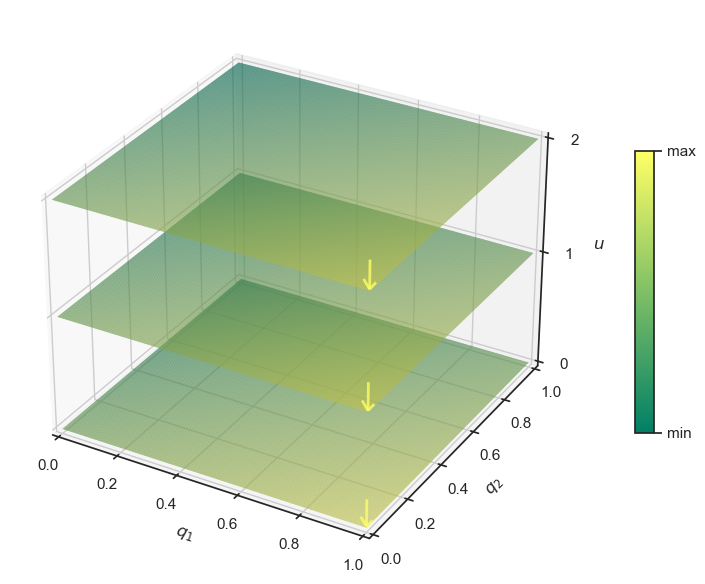

In [220]:
figure_reactive_ES(fsize = (8.5, 6), fs = 14)